# Embedding analysis through spectrogram manipulation

The aim of this script is to evaluate an embedding by manipulating spectrograms and assessing the influence of these manipulations on the euclidean distance in the embedded space.

# Prerequisites

## Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading libraries

In [2]:
import os
import pandas as pd
import sys
os.system('pip install "librosa==0.7.1"')
import librosa
import numpy as np
import statistics
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import umap
from scipy.stats import zscore
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
from matplotlib.text import Annotation
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
import scipy
from scipy.spatial.distance import euclidean as euclid
from scipy.spatial import distance_matrix

# for 3D arrow annotation
# https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c

class Annotation3D(Annotation):
    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0,0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, renderer.M)
        self.xy=(x2,y2)
        super().draw(renderer)

def _annotate3D(ax,text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation= Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D,'annotate3D',_annotate3D)

## Constants

In [3]:
PROJECT_PATH = "/content/drive/My Drive/meerkat/" 
FIGURES = PROJECT_PATH+"figures/"
DATA = PROJECT_PATH+"data/"

os.chdir(PROJECT_PATH)

In [ ]:
# Spectrogramming paramters

FFT_WIN = 0.03 # FFT_WIN*samplerate = length of fft/n_fft (number of audio frames that go in one fft)
FFT_HOP = FFT_WIN/8 # FFT_HOP*samplerate = n of audio frames between successive ffts
N_MELS = 40 # number of mel bins
WINDOW = 'hann' # each frame of audio is windowed by a window function (its length can also be
# determined and is then padded with zeros to match n_fft. we use window_length = length of fft
N_MFCC = 13 # Number of cepstral coefficients
#SR = 48000
#SR = 22050 # for padded
FMAX = 4000
MAX_DURATION = 0.5

## Functions

In [ ]:
def generate_stretched_old(audio_data, dur, sr):

    augmented_specs = []

    durations = np.linspace(0.01, MAX_DURATION-0.05, num=40)

    if dur not in durations:
      previous_element = np.max(durations[durations<dur])
      desired_index = np.where(durations==previous_element)[0][0]+1
      durations = np.insert(durations, desired_index, dur)

    n_fft  = int(FFT_WIN * sr) 
    hop_length = int(FFT_HOP * sr)
    
    for desired_duration in durations:
 
      stretch_rate = dur/desired_duration
      D = librosa.stft(y=audio_data, 
                       n_fft = n_fft,
                       hop_length = hop_length,
                       window=WINDOW,
                       win_length = n_fft
                       )
    
      D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
      D_stretched = librosa.power_to_db(np.abs(D_stretched)**2, ref=np.max) # power to db transform

    
      spectro = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                               sr=sr,
                                               n_mels=N_MELS,
                                               fmax=FMAX)
        
      #spectro = librosa.power_to_db(np.abs(s)**2, ref=np.max) # power to db transform
      
      # Denoise
      spectro = spectro-np.median(spectro, axis=0)
      
      augmented_specs.append(spectro)

    return augmented_specs


In [ ]:
# Function that pads a spectrogram with zeros to a certain length
# Input: spectrogram (2D np array)
#        maximal length (Integer)
# Output: Padded spectrogram (2D np array)

def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec


# shift timeframes to the right
def generate_timeshifted(original_spec):

  augmented_specs = []
  
  for k in range(1,(MAXLEN-original_spec.shape[1])):
    addition = np.zeros((original_spec.shape[0], k))
    augmented = np.append(addition, original_spec, axis=1)
    augmented_specs.append(augmented)

  return augmented_specs


# generate different stretches. need orignal raw-audio to do this.
def generate_stretched(audio_data, dur, sr):

    augmented_specs = []

    durations = np.linspace(0.05, 0.45, num=40)

    if dur not in durations:
      previous_element = np.max(durations[durations<dur])
      desired_index = np.where(durations==previous_element)[0][0]+1
      durations = np.insert(durations, desired_index, dur)

    n_fft  = int(FFT_WIN * sr) 
    hop_length = int(FFT_HOP * sr)
    
    for desired_duration in durations:
 
      stretch_rate = dur/desired_duration
      D = librosa.stft(y=audio_data, 
                       n_fft = n_fft,
                       hop_length = hop_length,
                       window=WINDOW,
                       win_length = n_fft
                       )

      D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
      #D_stretched = librosa.power_to_db(np.abs(D_stretched)**2, ref=np.max) # power to db transform

      D_stretched = np.abs(D_stretched)**2
      spectro = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                               sr=sr,
                                               n_mels=N_MELS,
                                               fmax=FMAX)
        
      #spectro = librosa.power_to_db(np.abs(spectro)**2, ref=np.max) # power to db transform
      spectro = librosa.power_to_db(spectro, ref=np.max) # power to db transform
      
      # Denoise
      spectro = spectro-np.median(spectro, axis=0)
      
      augmented_specs.append(spectro)

    return augmented_specs


def generate_freqshifted(original_spec):

  augmented_specs = []
  
  for k in range(1,N_MELS):
    upper = original_spec[0:k,:]
    lower = original_spec[k:,:]

    augmented = np.concatenate((lower, upper), axis=0)
    augmented_specs.append(augmented)

  return augmented_specs



def generate_augmented(call, augment_type):
  augmented = []

  if augment_type=='stretch':
    augmented = generate_stretched(call.raw_audio, call.duration_s, call.samplerate_hz)
    #augmented = generate_stretched_old(call.raw_audio, call.duration_s, call.samplerate_hz)
  elif augment_type=='timeshift':
    augmented = generate_timeshifted(call.denoised_spectrograms)
  elif augment_type=='freqshift':
    augmented = generate_freqshifted(call.denoised_spectrograms)
  else:
    print('Augmenttype not recognized')
  
  return augmented

# Analysis

After all, embeddings are just dim-reduced spectrograms, so makes sense to test with the spectrograms.

In [4]:
df = pd.read_pickle(DATA+'df_denoised_balanced')
df = df[df.nonfocal_yn == 'n'] # for focal
df.reset_index(inplace=True)
df['index_id_str'] = df['index_id'].values.astype(str)

Randomly sample an example for each calltype

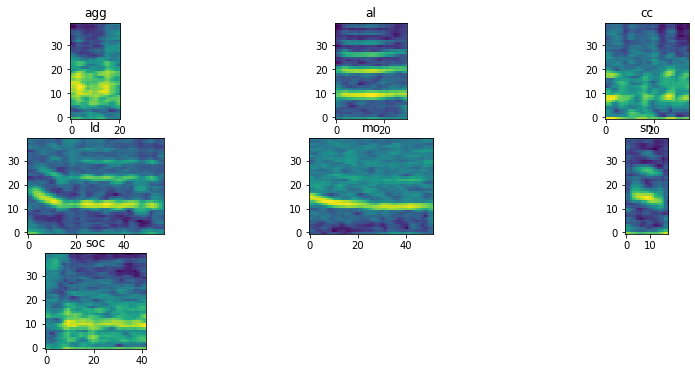

In [ ]:
call_dict={}
calltypes = sorted(list(set(df['call_lable'])))
for calltype in calltypes:
  example = df.loc[df['call_lable']==calltype,:].sample(n=1,replace=True, random_state=1234).squeeze() #1910
  call_dict[calltype] = example

fig = plt.figure(figsize=(14,6))
k=1

# Show examples
for calltype in calltypes:
  img_of_interest = call_dict[calltype].denoised_spectrograms
  plt.subplot(3, 3, k)
  plt.imshow(img_of_interest, interpolation='nearest', origin='lower', aspect='equal') 
  plt.title(calltype)
  k=k+1

## UMAP without augmented

In [ ]:
specs = list(df.denoised_spectrograms.values) 
maxlen= np.max([spec.shape[1] for spec in specs])

flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)

# Normalize
#data = StandardScaler().fit_transform(pd.DataFrame(data))

# UMAP
reducer = umap.UMAP(low_memory=True, n_components = 5, min_dist=0, random_state=2204)
df_embedding = reducer.fit_transform(data)
df_embedding.shape

(6687, 5)

## Visualize class representatives 

In [ ]:
x, y, z = df_embedding[:,0], df_embedding[:,1], df_embedding[:,2]
scat_labels = df.call_lable.values.copy()
labeltypes = sorted(list(set(scat_labels)))
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

size_vec = np.asarray([3]*df.shape[0])

for calltype in calltypes:
  scat_labels[df[df.index_id.values == call_dict[calltype].index_id].index.values[0]]='repr'
  size_vec[df[df.index_id.values == call_dict[calltype].index_id].index.values[0]]='12'
color_dict['repr'] = (1,0,0)

c = [color_dict[val] for val in scat_labels]


fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   hovertext = df.index_id_str.values+" "+df.Name.values,
                                   marker=dict(
                                       size=size_vec,
                                       color=c,                
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    zaxis_title='UMAP3'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

## Generate augmented

In [ ]:
calltype = 'al'
augment_type = 'stretch'

In [ ]:
specs = list(df.denoised_spectrograms.values) # now array of 2D arrays n_mels+time_frames(varying)
MAXLEN = np.max([spec.shape[1] for spec in specs])

original_spec = call_dict[calltype].denoised_spectrograms
augmented_specs = generate_augmented(call_dict[calltype], augment_type)

In [ ]:
# Add augmented to specs
all_specs = specs+augmented_specs
len(all_specs)

# Create data
flattened_specs = [pad_spectro(spec, MAXLEN).flatten() for spec in all_specs]
data = np.asarray(flattened_specs)
# Normalize
#data = StandardScaler().fit_transform(pd.DataFrame(data))

### Full spectrograms

In [ ]:
original_full_embedding = data[df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0],:]
augmented_full_embeddings = data[-(len(augmented_specs)):,:]

if augment_type=='stretch':
  lens = [spec.shape[1] for spec in augmented_specs]
  zero_stretch_index = lens.index(original_spec.shape[1])
  zerostretch_full_embedding = augmented_full_embeddings[zero_stretch_index,:]
  zerostretch_spec = augmented_specs[zero_stretch_index]

if augment_type!='freqshift':
  zerostretch_spec_padded = pad_spectro(zerostretch_spec, MAXLEN)
  original_spec_padded = pad_spectro(original_spec, MAXLEN)
  augmented_specs_padded = [pad_spectro(x, MAXLEN) for x in augmented_specs]

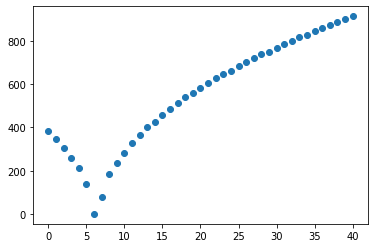

In [ ]:
distances = [euclid(zerostretch_full_embedding, augmented_full_embeddings[i,:]) for i in range(0,len(augmented_specs))]
plt.scatter(range(len(augmented_specs)), distances)

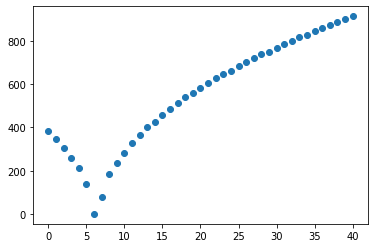

In [ ]:
distances = [euclid(original_full_embedding, augmented_full_embeddings[i,:]) for i in range(0,len(augmented_specs))]
plt.scatter(range(len(augmented_specs)), distances)

In [ ]:
euclid(original_full_embedding, zerostretch_full_embedding)

In [ ]:
original_spec[0:5,0:2]

In [ ]:
zerostretch_spec[0:5,0:2]

In [ ]:
pd.Series(np.asarray((original_spec == zerostretch_spec).flatten())).value_counts()

True     1098
False     102
dtype: int64

#### Visualization

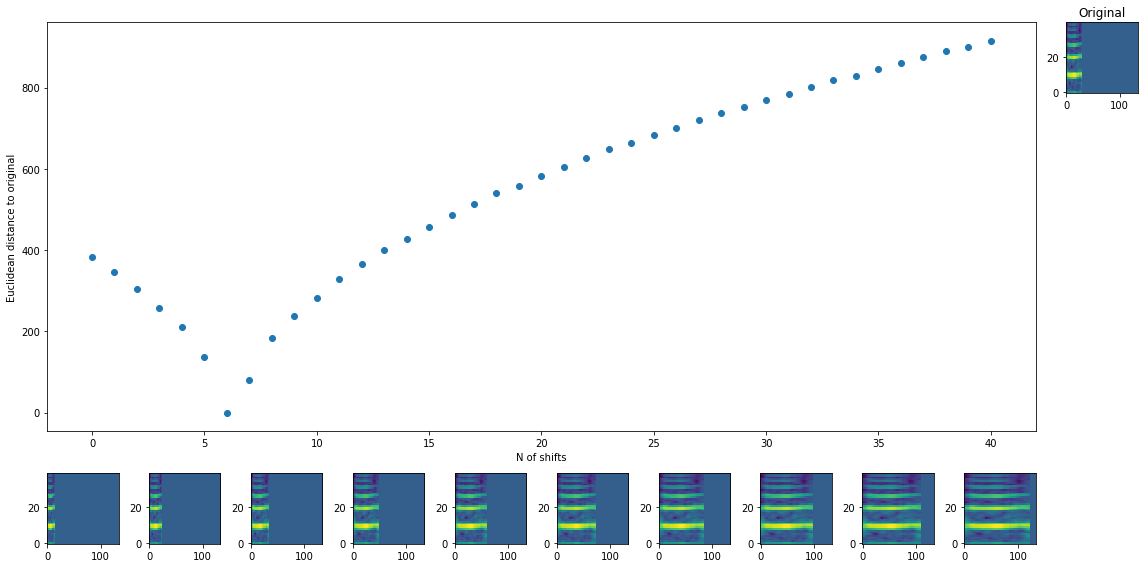

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(5, 11, fig)
fig.add_subplot(gs[:4, :10])
plt.scatter(range(len(augmented_specs)), distances)
plt.ylabel('Euclidean distance to original')
plt.xlabel('N of shifts')

# original spec on the very left
fig.add_subplot(gs[0, 10])
plt.imshow(original_spec_padded, interpolation='nearest', origin='lower', aspect='auto') 
plt.title('Original')

# the augmented specs to the right
interval_specs = np.linspace(0, len(augmented_specs)-1, num=10).astype(int)
for i in range(10):
  fig.add_subplot(gs[4, i])
  plt.imshow(augmented_specs_padded[interval_specs[i]], interpolation='nearest', origin='lower', aspect='auto') 

plt.tight_layout()

### Embeddings

In [ ]:
#flattened_specs = [pad_spectro(spec, MAXLEN).flatten() for spec in all_specs]
#data = np.asarray(flattened_specs)
# Normalize
#data = StandardScaler().fit_transform(pd.DataFrame(data))
data.shape

(6728, 5360)

In [ ]:
# UMAP
reducer = umap.UMAP(low_memory=True, n_components = 5, min_dist=0, random_state = 2204)
all_embedding = reducer.fit_transform(data)
all_embedding.shape

(6728, 5)

In [ ]:
specs_embeddings = all_embedding[0:-(len(augmented_specs)),:]
original_embedding = all_embedding[df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0],:]
augmented_embeddings = all_embedding[-(len(augmented_specs)):,:]

if augment_type=='stretch':
  lens = [spec.shape[1] for spec in augmented_specs]
  zero_stretch_index = lens.index(original_spec.shape[1])
  zerostretch_embedding = augmented_embeddings[zero_stretch_index,:] # can be a tiny bit different
  zerostretch_spec = augmented_specs[zero_stretch_index]

if augment_type!='freqshift':
  zerostretch_spec_padded = pad_spectro(zerostretch_spec, MAXLEN)
  augmented_specs_padded = [pad_spectro(x, MAXLEN) for x in augmented_specs]

distances = [euclid(zerostretch_embedding, augmented_embeddings[i,:]) for i in range(0,len(augmented_specs))]
#distances = [euclid(original_embedding, augmented_embeddings[i,:]) for i in range(0,len(augmented_specs))]

In [ ]:
euclid(zerostretch_embedding, original_embedding)

0.02135241962969303

In [ ]:
euclid(all_embedding[df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0],:], original_embedding)

0.0

#### Visualization

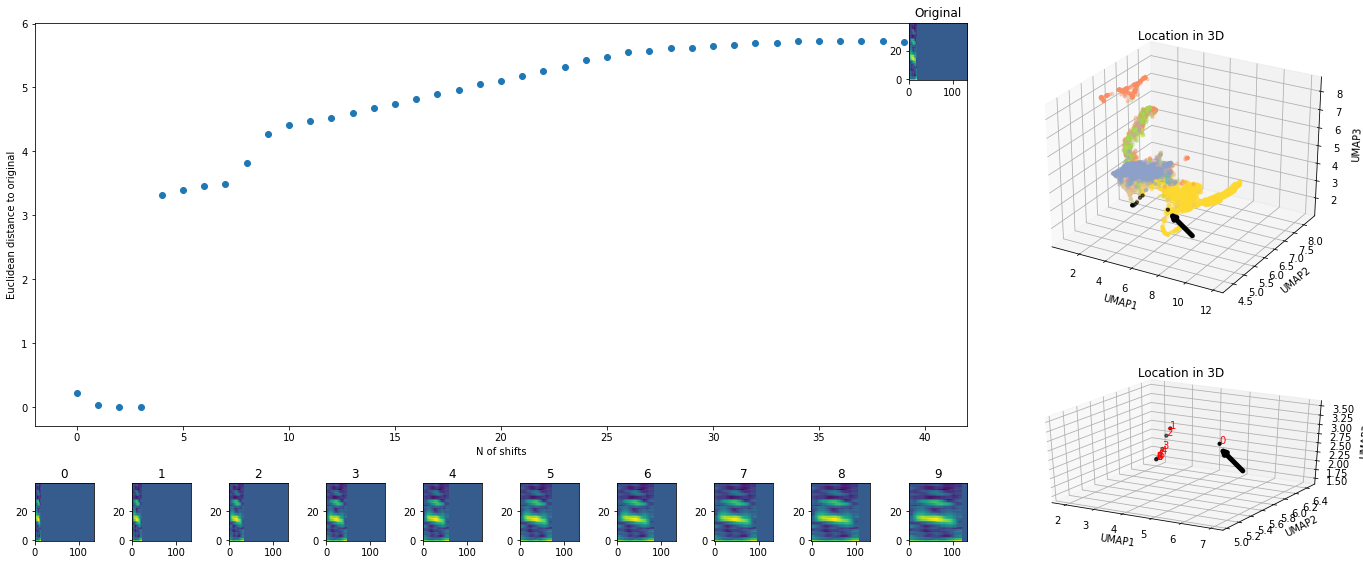

In [ ]:
interval_specs = np.linspace(0, len(augmented_specs)-1, num=10).astype(int)
augmented_10_embeddings = augmented_embeddings[interval_specs,:]
plot_embedding = np.concatenate((specs_embeddings, augmented_10_embeddings), axis=0)
original_row_num = df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0]

fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(5, 15, fig)
fig.add_subplot(gs[:4, 1:11])
plt.scatter(range(len(augmented_specs)), distances)
plt.ylabel('Euclidean distance to original')
plt.xlabel('N of shifts')

# The original in the corner
fig.add_subplot(gs[0, 10])
plt.imshow(original_spec_padded, interpolation='nearest', origin='lower', aspect='auto') 
plt.title('Original')


# the augmented specs to the right
for i in range(10):
  fig.add_subplot(gs[4, i+1])
  plt.imshow(augmented_specs_padded[interval_specs[i]], interpolation='nearest', origin='lower', aspect='auto')
  plt.title(str(i))

ax = fig.add_subplot(gs[0:3, 11:], projection='3d')
#ax = fig.add_subplot(111, projection='3d')

scat_labels = df['call_lable'].copy()
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

# change alpha param
for key in color_dict.keys():
  color_dict[key] = color_dict[key] +(0.5,)

# add special entry for augmented specs
color_dict[99] = (0,0,0,1) # black

scat_labels = np.asarray(scat_labels)
scat_labels[original_row_num] = 99
scat_labels = list(scat_labels)
scat_labels = scat_labels+[99]*10

# Adding color for representative datapoints
c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               #xs = embedding[:-len(augmented_specs),0],
               #ys = embedding[:-len(augmented_specs),1],
               #zs= embedding[:-len(augmented_specs),2],
               xs = plot_embedding[:,0],
               ys = plot_embedding[:,1],
               zs= plot_embedding[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=True)

# put in arrow
if augment_type=='stretch':
  ax.annotate3D('',(augmented_embeddings[zero_stretch_index,0],augmented_embeddings[zero_stretch_index,1],augmented_embeddings[zero_stretch_index,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))
else:
  ax.annotate3D('',(embedding[original_row_num,0],embedding[original_row_num,1],embedding[original_row_num,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))


ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('Location in 3D')


ax = fig.add_subplot(gs[3:, 11:], projection='3d')
scat_labels = np.arange(0,10,1)
c = [(0,0,0,1) for val in scat_labels]

Axes3D.scatter(ax,
               #xs = embedding[:-len(augmented_specs),0],
               #ys = embedding[:-len(augmented_specs),1],
               #zs= embedding[:-len(augmented_specs),2],
               xs = augmented_10_embeddings[:,0],
               ys = augmented_10_embeddings[:,1],
               zs= augmented_10_embeddings[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=True)

# put in arrow
if augment_type=='stretch':
  ax.annotate3D('',(augmented_embeddings[zero_stretch_index,0],augmented_embeddings[zero_stretch_index,1],augmented_embeddings[zero_stretch_index,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))
else:
  ax.annotate3D('',(embedding[original_row_num,0],embedding[original_row_num,1],embedding[original_row_num,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))

# simple way, only text, no arrow:
for i in scat_labels:
  ax.text(augmented_10_embeddings[i,0],
          augmented_10_embeddings[i,1],
          augmented_10_embeddings[i,2],
          str(i), color='red')


ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('Location in 3D')


plt.tight_layout() 

plt.savefig(FIGURES+'embed_augment_'+calltype+'.jpg')

In [ ]:
x, y, z = plot_embedding[:,0], plot_embedding[:,1], plot_embedding[:,2]
scat_labels = df.call_lable.values.copy()

labeltypes = sorted(list(set(scat_labels)))
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
scat_labels = list(scat_labels)
scat_labels = scat_labels+[99]*10
color_dict[99] = (0,0,0)


c = [color_dict[val] for val in scat_labels]


fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   hovertext = df.index_id_str.values+" "+df.Name.values,
                                   marker=dict(
                                       size=2,
                                       color=c,                # set color to an array/list of desired values
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    zaxis_title='UMAP3'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [ ]:
x, y, z = specs_embeddings[:,0], specs_embeddings[:,1], specs_embeddings[:,2]
scat_labels = df.call_lable.values.copy()
labeltypes = sorted(list(set(scat_labels)))
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

size_vec = np.asarray([3]*df.shape[0])


scat_labels[df[df.index_id.values == call_dict[calltype].index_id].index.values[0]]='repr'
size_vec[df[df.index_id.values == call_dict[calltype].index_id].index.values[0]]='12'
color_dict['repr'] = (1,0,0)

c = [color_dict[val] for val in scat_labels]


fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   hovertext = df.index_id_str.values+" "+df.Name.values,
                                   marker=dict(
                                       #size=1,
                                       #color=c,
                                       size=size_vec,
                                       color=c,                # set color to an array/list of desired values
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    zaxis_title='UMAP3'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

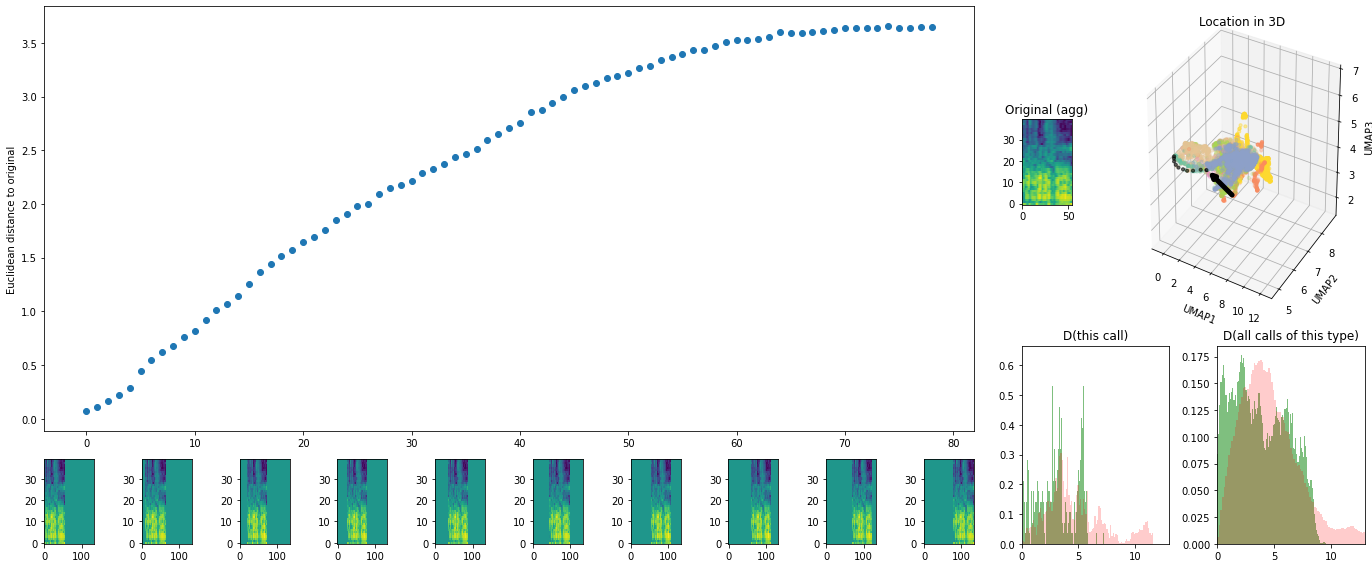

In [ ]:
ymax = int(np.max([np.max(distmat_call_vals), 
               np.max(distmat_not_call_vals),
               np.max(distmat_call_vals_1),
               np.max(distmat_not_call_vals_1),
               ]))

interval_specs = np.linspace(0, len(augmented_specs)-1, num=10).astype(int)
augmented_10_embeddings = augmented_embeddings[interval_specs,:]
plot_embedding = np.concatenate((specs_embeddings, augmented_10_embeddings), axis=0)
original_row_num = df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0]

fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(5, 15, fig)
fig.add_subplot(gs[:4, 1:11])
plt.scatter(range(len(augmented_specs)), distances)
plt.ylabel('Euclidean distance to original')

# the augmented specs to the right
for i in range(10):
  fig.add_subplot(gs[4, i+1])
  plt.imshow(augmented_specs[interval_specs[i]], interpolation='nearest', origin='lower', aspect='auto') 

fig.add_subplot(gs[1:2, 11:12])
plt.imshow(call_dict[calltype].denoised_spectrograms, interpolation='nearest', origin='lower', aspect='auto') 
plt.title("Original ("+call_dict[calltype].call_lable+")")

fig.add_subplot(gs[3:5, 11:13])
n, bins, patches = plt.hist(distmat_call_vals_1, bins=100, alpha=0.5, color='green', density=True)
n, bins, patches = plt.hist(distmat_not_call_vals_1, bins=100, alpha=0.2, color='red', density=True)
plt.xlim([0, ymax])
plt.title("D(this call)")

fig.add_subplot(gs[3:5, 13:])
n, bins, patches = plt.hist(distmat_call_vals, bins=100, alpha=0.5, color='green',density=True)
n, bins, patches = plt.hist(distmat_not_call_vals, bins=100, alpha=0.2, color='red',density=True)
plt.xlim([0, ymax])
plt.title("D(all calls of this type)")

ax = fig.add_subplot(gs[0:3, 12:], projection='3d')
#ax = fig.add_subplot(111, projection='3d')

scat_labels = df['call_lable'].copy()
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

# change alpha param
for key in color_dict.keys():
  color_dict[key] = color_dict[key] +(0.5,)

# add special entry for augmented specs
color_dict[99] = (0,0,0,1) # black

scat_labels = np.asarray(scat_labels)
scat_labels[original_row_num] = 99
scat_labels = list(scat_labels)
scat_labels = scat_labels+[99]*10

# Adding color for representative datapoints
c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               #xs = embedding[:-len(augmented_specs),0],
               #ys = embedding[:-len(augmented_specs),1],
               #zs= embedding[:-len(augmented_specs),2],
               xs = plot_embedding[:,0],
               ys = plot_embedding[:,1],
               zs= plot_embedding[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=True)

# put in arrow
ax.annotate3D('',(embedding[original_row_num,0],embedding[original_row_num,1],embedding[original_row_num,2]),
              xytext=(30,-30),
              textcoords='offset points',
              bbox=dict(boxstyle="round", fc="lightyellow"),
              arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('Location in 3D')

plt.tight_layout() 

plt.savefig(FIGURES+'augment_'+calltype+'.jpg')

# Try with UMAP transform of augmented specs

Run UMAP once with the original dataset. Then create augmented specs, encode them as part of the full dataframe (because of z-transform), then project them into existing UMAP space.

In [ ]:
# Original embeddings (only once)

specs = list(df.denoised_spectrograms.values) # now array of 2D arrays n_mels+time_frames(varying)
MAXLEN = np.max([spec.shape[1] for spec in specs])
# Create data
flattened_specs = [pad_spectro(spec, MAXLEN).flatten() for spec in specs]
data = np.asarray(flattened_specs)
# Normalize
#data = StandardScaler().fit_transform(pd.DataFrame(data))


# UMAP
reducer = umap.UMAP(low_memory=True, n_components = 5, min_dist=0, random_state=2204)
umap_res = reducer.fit(data)
specs_embeddings_solo = umap_res.embedding_
specs_embeddings_solo.shape


(6687, 5)

In [ ]:
calltype = 'soc'

In [ ]:
# Create augmented specs

original_spec = call_dict[calltype].denoised_spectrograms
augmented_specs = generate_augmented(call_dict[calltype],'stretch')


# Create data if z-norm
# all_specs = specs+augmented_specs
#specs_full_embeddings = [pad_spectro(spec, MAXLEN).flatten() for spec in all_specs]
#all_data = np.asarray(specs_full_embeddings)
# Normalize
#all_data = StandardScaler().fit_transform(pd.DataFrame(all_data))
# augmented_data = all_data[-len(augmented_specs):,:]

augmented_data = np.asarray([pad_spectro(spec, MAXLEN).flatten() for spec in augmented_specs])
augmented_data.shape


(41, 5360)

In [ ]:
# Project these new datapoints into UMAP space:
augmented_embeddings = np.zeros((augmented_data.shape[0],5))

for i in range(augmented_data.shape[0]):
  augmented_embeddings[i,:] = umap_res.transform(augmented_data[i:i+1,])

In [ ]:
if augment_type=='stretch':
  lens = [spec.shape[1] for spec in augmented_specs]
  zero_stretch_index = lens.index(original_spec.shape[1])
  zerostretch_embedding = augmented_embeddings[zero_stretch_index,:] # can be a tiny bit different
  zerostretch_spec = augmented_specs[zero_stretch_index]


# Calculate distances

original_embedding = specs_embeddings_solo[df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0],:]
distances = [euclid(original_embedding, augmented_embeddings[i,:]) for i in range(0,len(augmented_specs))]
#distances = [euclid(zero_stretch_embedding, augmented_embeddings[i,:]) for i in range(0,len(augmented_specs))]

# Pad for plot
original_spec_padded = pad_spectro(original_spec, MAXLEN)
augmented_specs_padded = [pad_spectro(x, MAXLEN) for x in augmented_specs]

In [ ]:
durations = np.linspace(0.01, MAX_DURATION-0.05, num=40)
dur = call_dict[calltype].duration_s
if dur not in durations:
  previous_element = np.max(durations[durations<dur])
  desired_index = np.where(durations==previous_element)[0][0]+1
  durations = np.insert(durations, desired_index, dur)

scatter_tick_labels = [int(x*1000) for x in durations]

for i in range(len(scatter_tick_labels)):
  if i not in interval_specs:
    scatter_tick_labels[i] = ''

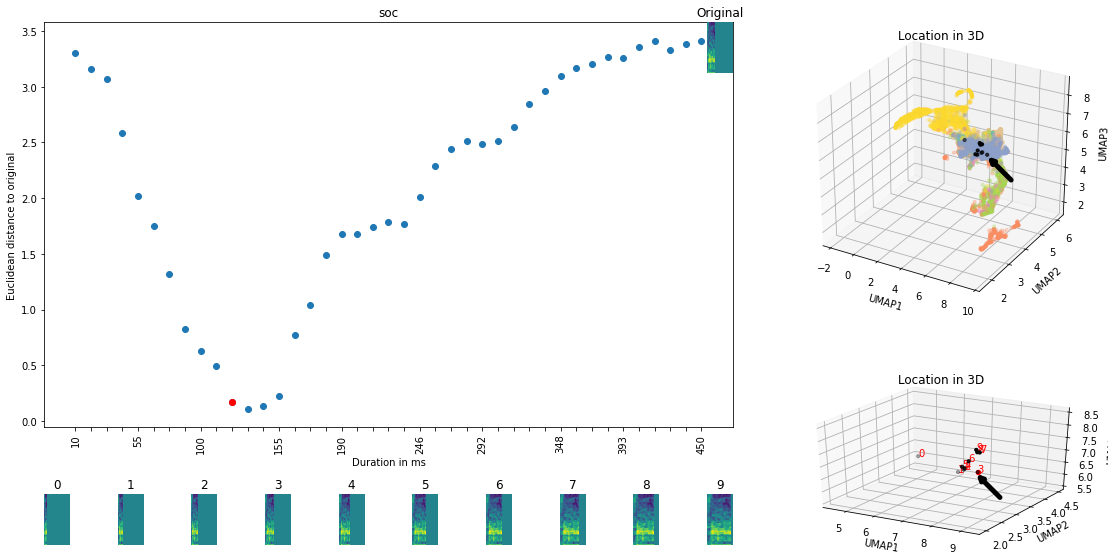

In [ ]:
interval_specs = np.linspace(0, len(augmented_specs)-1, num=10).astype(int)
augmented_10_embeddings = augmented_embeddings[interval_specs,:]
plot_embedding = np.concatenate((specs_embeddings_solo, augmented_10_embeddings), axis=0)
original_row_num = df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0]

fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(5, 16, fig)
fig.add_subplot(gs[:4, 1:11])
plt.scatter(range(len(augmented_specs)), distances)

plt.scatter(zero_stretch_index, distances[zero_stretch_index], color='red')

plt.xticks(range(len(augmented_specs)), scatter_tick_labels, rotation='vertical')
plt.ylabel('Euclidean distance to original')
#plt.xlabel('N of shifts')
plt.title(calltype)
plt.xlabel('Duration in ms')

# The original in the corner
fig.add_subplot(gs[0, 10])
plt.imshow(original_spec_padded, interpolation='nearest', origin='lower', aspect='auto') 
plt.axis('off')
plt.title('Original')


# the augmented specs to the right
for i in range(10):
  fig.add_subplot(gs[4, i+1])
  plt.imshow(augmented_specs_padded[interval_specs[i]], interpolation='nearest', origin='lower', aspect='auto')
  plt.axis('off')
  plt.title(str(i))

ax = fig.add_subplot(gs[0:3, 11:], projection='3d')
#ax = fig.add_subplot(111, projection='3d')

scat_labels = df['call_lable'].copy()
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

# change alpha param
for key in color_dict.keys():
  color_dict[key] = color_dict[key] +(0.5,)

# add special entry for augmented specs
color_dict[99] = (0,0,0,1) # black

scat_labels = np.asarray(scat_labels)
scat_labels[original_row_num] = 99
scat_labels = list(scat_labels)
scat_labels = scat_labels+[99]*10

# Adding color for representative datapoints
c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               #xs = embedding[:-len(augmented_specs),0],
               #ys = embedding[:-len(augmented_specs),1],
               #zs= embedding[:-len(augmented_specs),2],
               xs = plot_embedding[:,0],
               ys = plot_embedding[:,1],
               zs= plot_embedding[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=True)


# put in arrow
if augment_type=='stretch':
  ax.annotate3D('',(augmented_embeddings[zero_stretch_index,0],augmented_embeddings[zero_stretch_index,1],augmented_embeddings[zero_stretch_index,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))
else:
  ax.annotate3D('',(embedding[original_row_num,0],embedding[original_row_num,1],embedding[original_row_num,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('Location in 3D')


ax = fig.add_subplot(gs[3:, 11:], projection='3d')
scat_labels = np.arange(0,10,1)
c = [(0,0,0,1) for val in scat_labels]

Axes3D.scatter(ax,
               xs = augmented_10_embeddings[:,0],
               ys = augmented_10_embeddings[:,1],
               zs= augmented_10_embeddings[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=True)

# Add original datapoint
Axes3D.scatter(ax,
               xs = original_embedding[0],
               ys = original_embedding[1],
               zs = original_embedding[2],
               c='red' 
               )

# put in arrow
if augment_type=='stretch':
  ax.annotate3D('',(augmented_embeddings[zero_stretch_index,0],augmented_embeddings[zero_stretch_index,1],augmented_embeddings[zero_stretch_index,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))
else:
  ax.annotate3D('',(embedding[original_row_num,0],embedding[original_row_num,1],embedding[original_row_num,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))

# simple way, only text, no arrow:
for i in scat_labels:
  ax.text(augmented_10_embeddings[i,0],
          augmented_10_embeddings[i,1],
          augmented_10_embeddings[i,2],
          str(i), color='red')

#ax.set_xlim([np.min(augmented_10_embeddings[:,0]), np.max(augmented_10_embeddings[:,0])])
#ax.set_ylim([np.min(augmented_10_embeddings[:,1]), np.max(augmented_10_embeddings[:,1])])
#ax.set_zlim([np.min(augmented_10_embeddings[:,2]), np.max(augmented_10_embeddings[:,2])])


ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('Location in 3D')


plt.tight_layout() 

plt.savefig(FIGURES+'augment_'+calltype+'.jpg')

# Loop

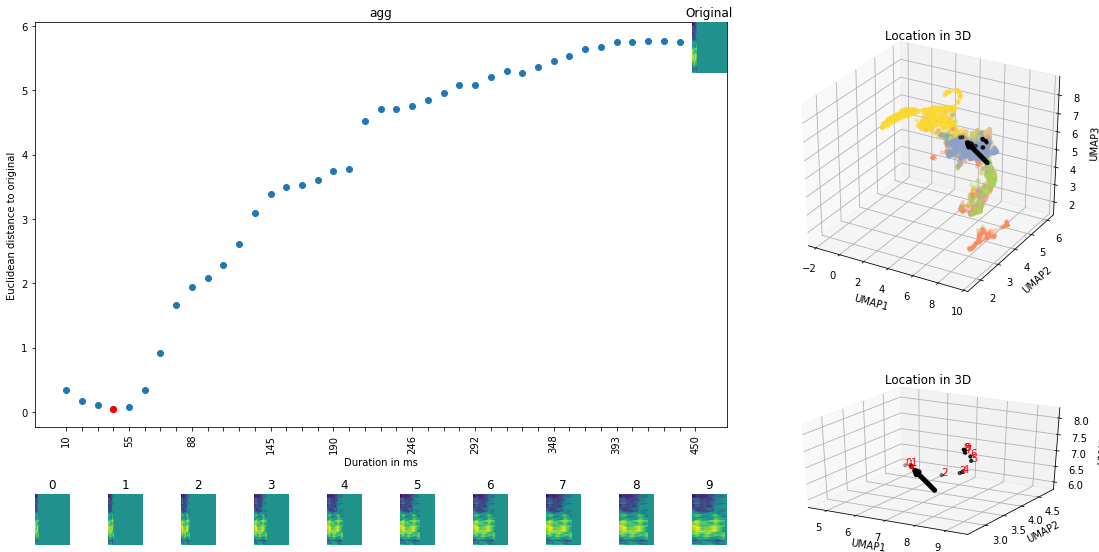

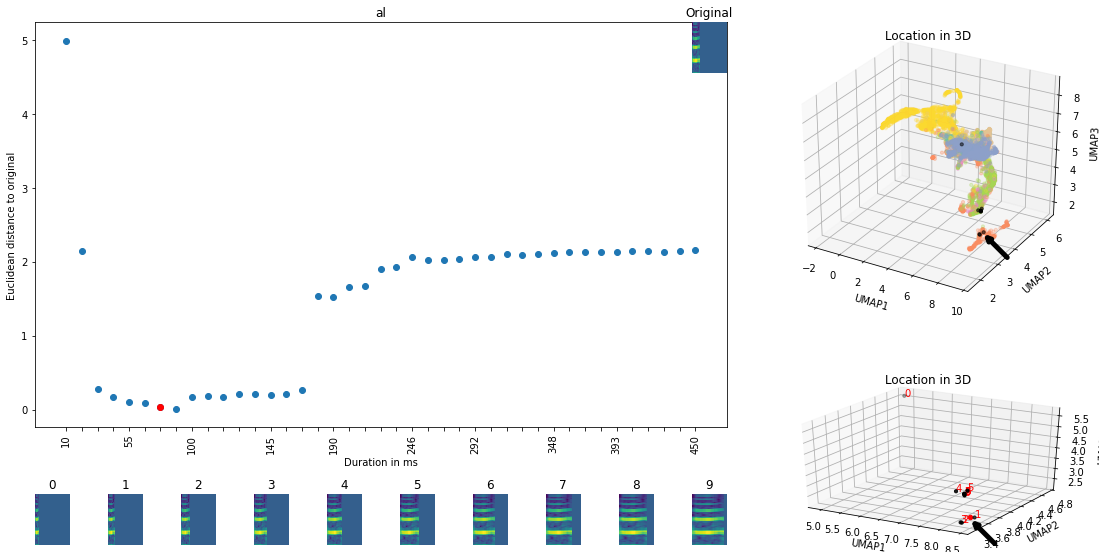

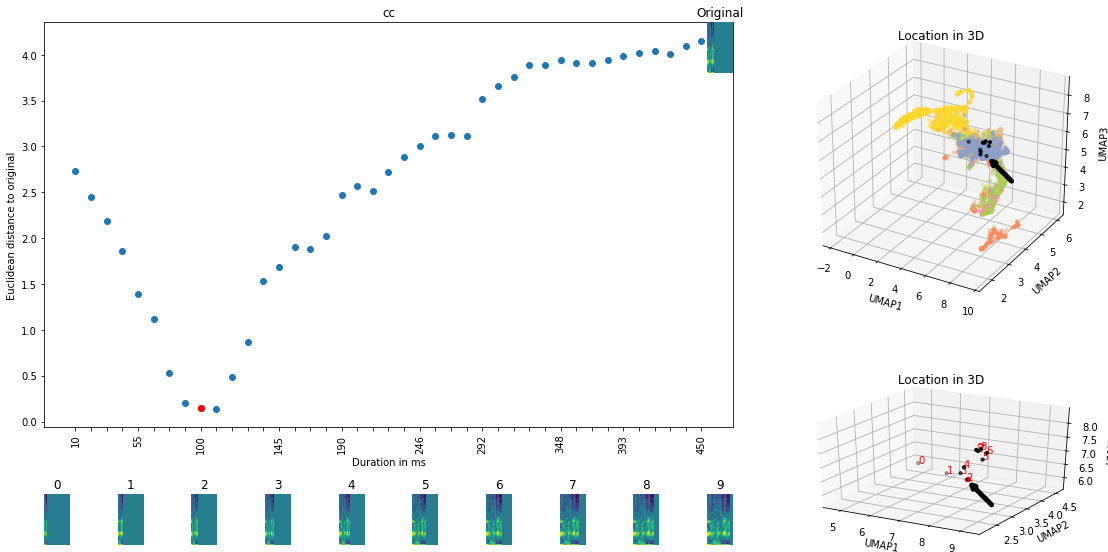

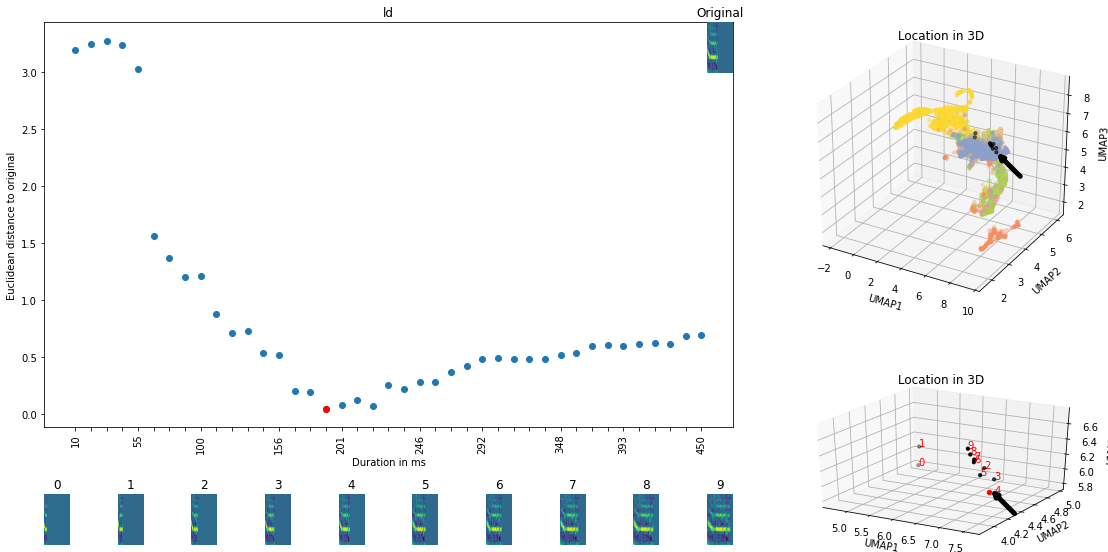

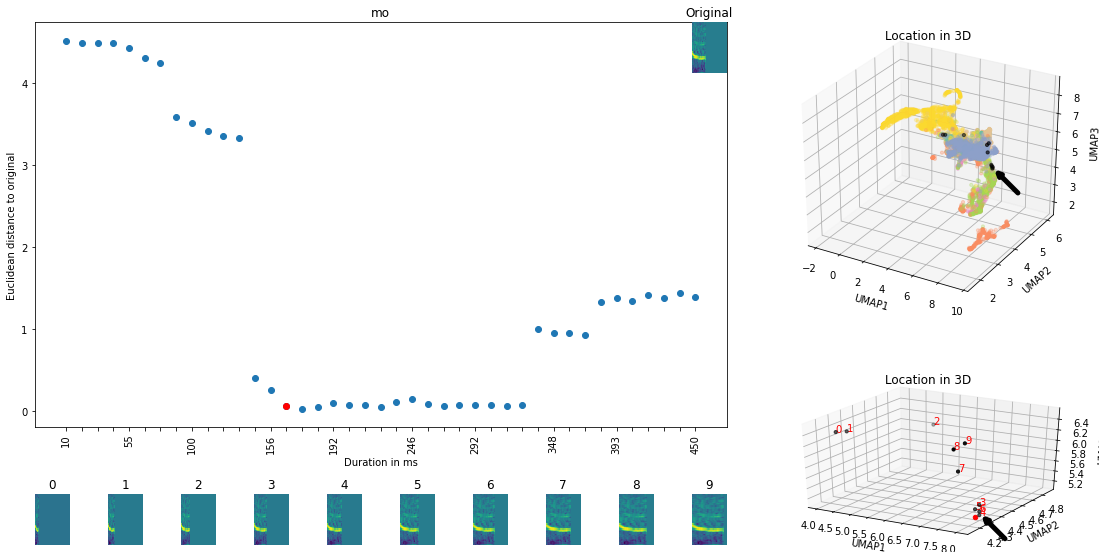

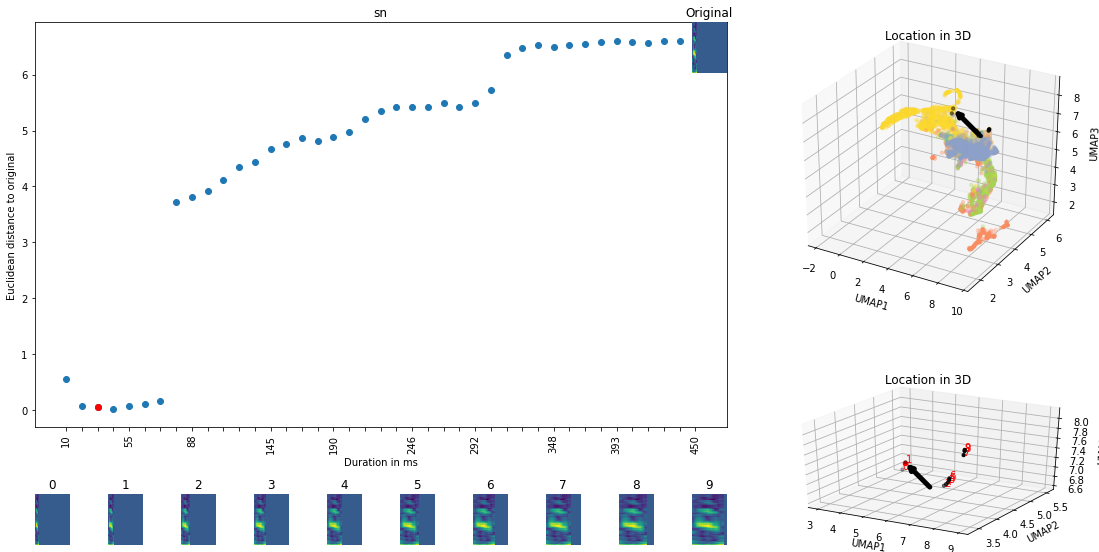

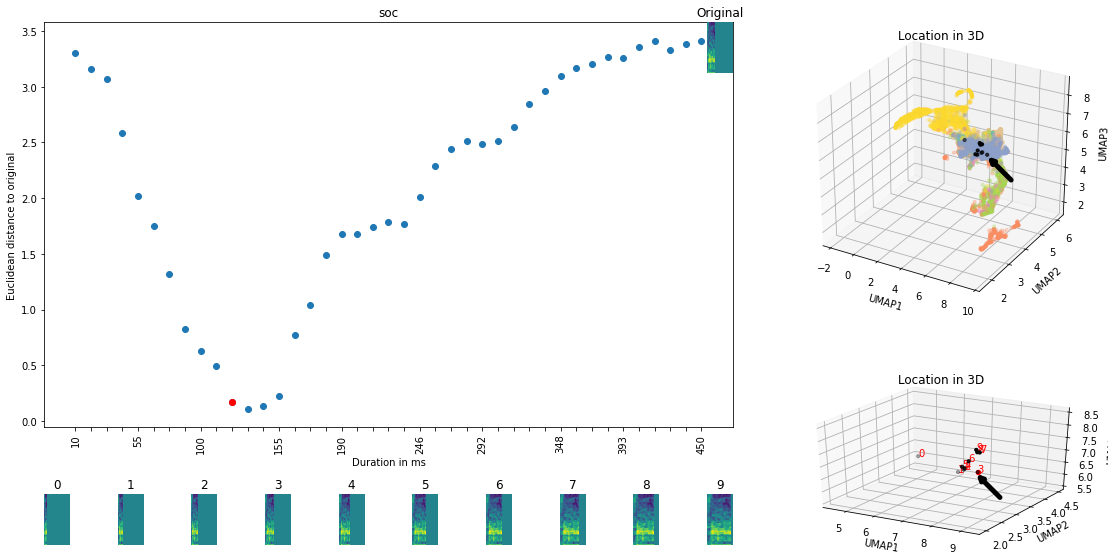

In [ ]:
for calltype in calltypes:
  original_spec= call_dict[calltype].denoised_spectrograms 
  augmented_specs = generate_augmented(call_dict[calltype],'stretch')
  augmented_data = np.asarray([pad_spectro(spec, MAXLEN).flatten() for spec in augmented_specs])
  augmented_data.shape
  # Project these new datapoints into UMAP space:
  augmented_embeddings = np.zeros((augmented_data.shape[0],5))

  for i in range(augmented_data.shape[0]):
    augmented_embeddings[i,:] = umap_res.transform(augmented_data[i:i+1,])

  if augment_type=='stretch':
    lens = [spec.shape[1] for spec in augmented_specs]
    zero_stretch_index = lens.index(original_spec.shape[1])
    zerostretch_embedding = augmented_embeddings[zero_stretch_index,:] # can be a tiny bit different
    zerostretch_spec = augmented_specs[zero_stretch_index]


  # Calculate distances

  original_embedding = specs_embeddings_solo[df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0],:]
  distances = [euclid(original_embedding, augmented_embeddings[i,:]) for i in range(0,len(augmented_specs))]

  # Pad for plot
  original_spec_padded = pad_spectro(original_spec, MAXLEN)
  augmented_specs_padded = [pad_spectro(x, MAXLEN) for x in augmented_specs]

  durations = np.linspace(0.01, MAX_DURATION-0.05, num=40)
  dur = call_dict[calltype].duration_s
  if dur not in durations:
    previous_element = np.max(durations[durations<dur])
    desired_index = np.where(durations==previous_element)[0][0]+1
    durations = np.insert(durations, desired_index, dur)

  scatter_tick_labels = [int(x*1000) for x in durations]

  for i in range(len(scatter_tick_labels)):
    if i not in interval_specs:
      scatter_tick_labels[i] = ''
  
  interval_specs = np.linspace(0, len(augmented_specs)-1, num=10).astype(int)
  augmented_10_embeddings = augmented_embeddings[interval_specs,:]
  plot_embedding = np.concatenate((specs_embeddings_solo, augmented_10_embeddings), axis=0)
  original_row_num = df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0]


  # Plot
  fig = plt.figure(figsize=(16,8))
  gs = gridspec.GridSpec(5, 16, fig)
  fig.add_subplot(gs[:4, 1:11])
  plt.scatter(range(len(augmented_specs)), distances)

  plt.scatter(zero_stretch_index, distances[zero_stretch_index], color='red')

  plt.xticks(range(len(augmented_specs)), scatter_tick_labels, rotation='vertical')
  plt.ylabel('Euclidean distance to original')
  #plt.xlabel('N of shifts')
  plt.title(calltype)
  plt.xlabel('Duration in ms')

  # The original in the corner
  fig.add_subplot(gs[0, 10])
  plt.imshow(original_spec_padded, interpolation='nearest', origin='lower', aspect='auto') 
  plt.axis('off')
  plt.title('Original')


  # the augmented specs to the right
  for i in range(10):
    fig.add_subplot(gs[4, i+1])
    plt.imshow(augmented_specs_padded[interval_specs[i]], interpolation='nearest', origin='lower', aspect='auto')
    plt.axis('off')
    plt.title(str(i))

  ax = fig.add_subplot(gs[0:3, 11:], projection='3d')
  #ax = fig.add_subplot(111, projection='3d')

  scat_labels = df['call_lable'].copy()
  labeltypes = sorted(list(set(scat_labels)))

  # makes colors same as AVGN visualization
  pal = sns.color_palette("Set2", n_colors=len(labeltypes))
  color_dict = dict(zip(labeltypes, pal))

  # change alpha param
  for key in color_dict.keys():
    color_dict[key] = color_dict[key] +(0.5,)

  # add special entry for augmented specs
  color_dict[99] = (0,0,0,1) # black

  scat_labels = np.asarray(scat_labels)
  scat_labels[original_row_num] = 99
  scat_labels = list(scat_labels)
  scat_labels = scat_labels+[99]*10

  # Adding color for representative datapoints
  c = [color_dict[val] for val in scat_labels]

  Axes3D.scatter(ax,
                #xs = embedding[:-len(augmented_specs),0],
                #ys = embedding[:-len(augmented_specs),1],
                #zs= embedding[:-len(augmented_specs),2],
                xs = plot_embedding[:,0],
                ys = plot_embedding[:,1],
                zs= plot_embedding[:,2],
                zdir='z',
                s=10,
                label = c,
                c=c,
                depthshade=True)


  # put in arrow
  if augment_type=='stretch':
    ax.annotate3D('',(augmented_embeddings[zero_stretch_index,0],augmented_embeddings[zero_stretch_index,1],augmented_embeddings[zero_stretch_index,2]),
                  xytext=(30,-30),
                  textcoords='offset points',
                  bbox=dict(boxstyle="round", fc="lightyellow"),
                  arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))
  else:
    ax.annotate3D('',(embedding[original_row_num,0],embedding[original_row_num,1],embedding[original_row_num,2]),
                  xytext=(30,-30),
                  textcoords='offset points',
                  bbox=dict(boxstyle="round", fc="lightyellow"),
                  arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))

  ax.set_xlabel('UMAP1')
  ax.set_ylabel('UMAP2')
  ax.set_zlabel('UMAP3')
  ax.set_title('Location in 3D')


  ax = fig.add_subplot(gs[3:, 11:], projection='3d')
  scat_labels = np.arange(0,10,1)
  c = [(0,0,0,1) for val in scat_labels]

  Axes3D.scatter(ax,
                xs = augmented_10_embeddings[:,0],
                ys = augmented_10_embeddings[:,1],
                zs= augmented_10_embeddings[:,2],
                zdir='z',
                s=10,
                label = c,
                c=c,
                depthshade=True)

  # Add original datapoint
  Axes3D.scatter(ax,
                xs = original_embedding[0],
                ys = original_embedding[1],
                zs = original_embedding[2],
                c='red' 
                )

  # put in arrow
  if augment_type=='stretch':
    ax.annotate3D('',(augmented_embeddings[zero_stretch_index,0],augmented_embeddings[zero_stretch_index,1],augmented_embeddings[zero_stretch_index,2]),
                  xytext=(30,-30),
                  textcoords='offset points',
                  bbox=dict(boxstyle="round", fc="lightyellow"),
                  arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))
  else:
    ax.annotate3D('',(embedding[original_row_num,0],embedding[original_row_num,1],embedding[original_row_num,2]),
                  xytext=(30,-30),
                  textcoords='offset points',
                  bbox=dict(boxstyle="round", fc="lightyellow"),
                  arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))

  # simple way, only text, no arrow:
  for i in scat_labels:
    ax.text(augmented_10_embeddings[i,0],
            augmented_10_embeddings[i,1],
            augmented_10_embeddings[i,2],
            str(i), color='red')

  ax.set_xlabel('UMAP1')
  ax.set_ylabel('UMAP2')
  ax.set_zlabel('UMAP3')
  ax.set_title('Location in 3D')


  plt.tight_layout() 

  plt.savefig(FIGURES+'augment_'+calltype+'.jpg')

# Duration histogram

In [5]:
df.shape

(6687, 37)

In [6]:
labels = df.call_lable.values
calltypes=sorted(list(set(labels)))

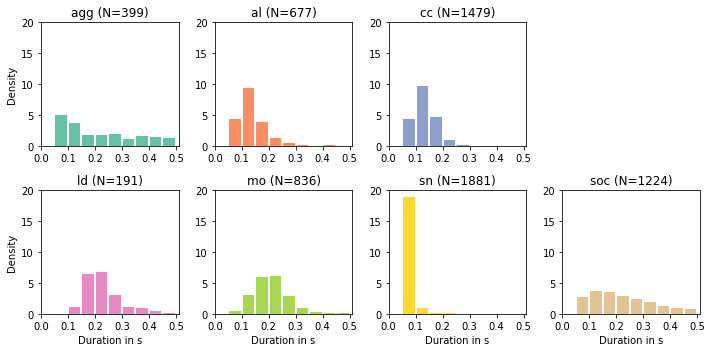

In [49]:
fig = plt.figure(figsize=(10, 5))

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))

bin_param = 'auto'
density_param = True
limit_axis = True
x_lim_lower = 20
x_lim_upper = 80


for i,calltype in zip([1,2,3,5,6,7,8], calltypes):
  plt.subplot(2, 4, i)
  subset_df = df[df['call_lable']==calltype]
  nx, bins, patches = plt.hist(x=subset_df.duration_s.values, 
                               #bins = 'auto',
                               #bins=int(subset_df.shape[0]/10),
                               bins = np.arange(0,0.55,0.05).tolist(),
                               density=density_param,
                               color=color_dict[calltype],
                               rwidth=0.85)
  #plt.ylim(0,230)
  plt.ylim(0,20)
  plt.xlim(0,0.51)
  plt.xticks(np.arange(0, 0.6, 0.1))
  if i in [1,5]:
    plt.ylabel("Density")
  if i in [5,6,7,8]:
    plt.xlabel("Duration in s")

  plt.title(calltype+" (N="+str(subset_df.shape[0])+")")
plt.tight_layout()
plt.savefig(FIGURES+'duration_hist.png')

In [37]:
np.arange(0, 0.6, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5])



```
# Als Code formatiert
```

Original space: (continuous)

In [ ]:
for i in range(10):
  print(euclid(augmented_embeddings[zero_stretch_index], augmented_embeddings[i]))

0.5784377981664355
0.0766767532498889
0.0
0.06484201460550215
0.07326138203672858
0.1357476446660943
0.17936287853687882
3.7592363315595563
3.8584906031405377
3.9537879298363823


Embedded space (steps):

In [ ]:
for i in range(10):
  print(euclid(augmented_full_embeddings[zero_stretch_index], augmented_full_embeddings[i]))

22.47206841253286
11.103232514316403
0.0
8.34260739849578
20.666608861785893
28.667981982121606
34.72510554968384
39.260376152207975
43.704601088881944
47.79464718911587


Why? Is there some mistake somewhere!?

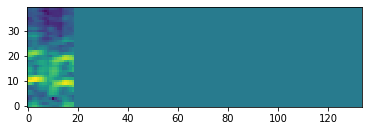

In [ ]:
plt.imshow(pad_spectro(call_dict[calltype].denoised_spectrograms, MAXLEN),interpolation='nearest', origin='lower', aspect='equal')

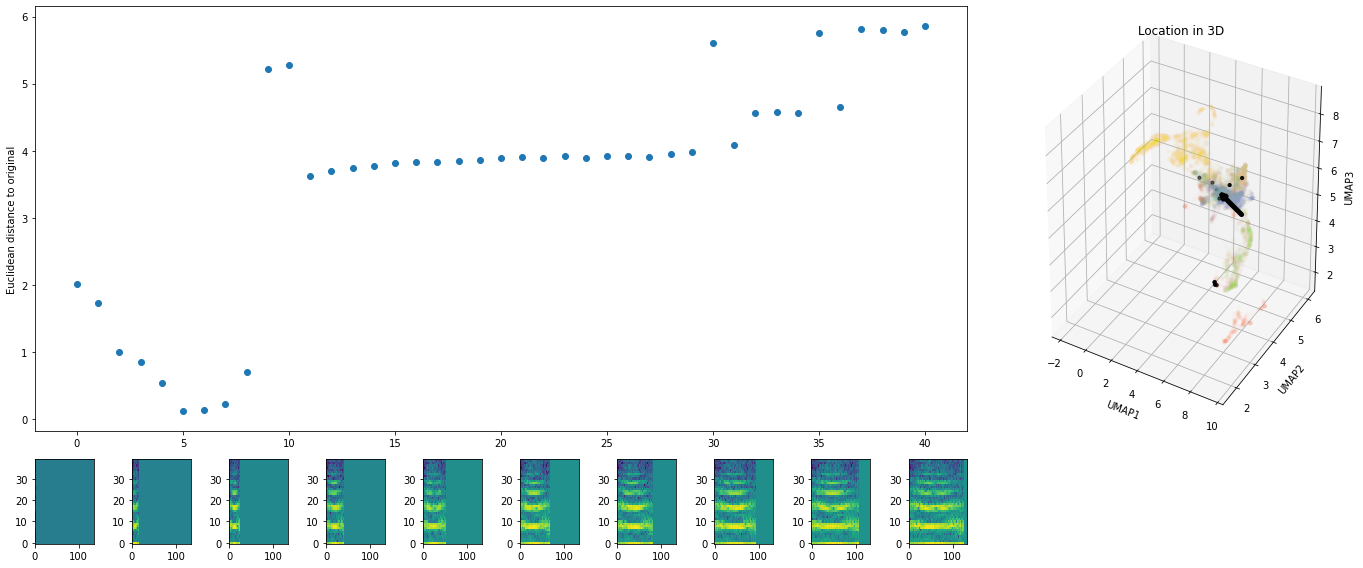

In [ ]:
interval_specs = np.linspace(0, len(augmented_specs)-1, num=10).astype(int)
augmented_10_embeddings = augmented_embeddings[interval_specs,:]
plot_embedding = np.concatenate((specs_embeddings, augmented_10_embeddings), axis=0)
original_row_num = df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0]

fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(5, 15, fig)
fig.add_subplot(gs[:4, 1:11])
plt.scatter(range(len(augmented_specs)), distances)
plt.ylabel('Euclidean distance to original')

# the augmented specs to the right
for i in range(10):
  fig.add_subplot(gs[4, i+1])
  plt.imshow(augmented_specs[interval_specs[i]], interpolation='nearest', origin='lower', aspect='auto') 

ax = fig.add_subplot(gs[0:4, 11:], projection='3d')
#ax = fig.add_subplot(111, projection='3d')

scat_labels = df['call_lable'].copy()
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

# change alpha param
for key in color_dict.keys():
  color_dict[key] = color_dict[key] +(0.05,)

# add special entry for augmented specs
color_dict[99] = (0,0,0,1) # black

scat_labels = np.asarray(scat_labels)
scat_labels[original_row_num] = 99
scat_labels = list(scat_labels)
scat_labels = scat_labels+[99]*10

# Adding color for representative datapoints
c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               #xs = embedding[:-len(augmented_specs),0],
               #ys = embedding[:-len(augmented_specs),1],
               #zs= embedding[:-len(augmented_specs),2],
               xs = plot_embedding[:,0],
               ys = plot_embedding[:,1],
               zs= plot_embedding[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=True)

# put in arrow
ax.annotate3D('',(plot_embedding[original_row_num,0],plot_embedding[original_row_num,1],plot_embedding[original_row_num,2]),
              xytext=(30,-30),
              textcoords='offset points',
              bbox=dict(boxstyle="round", fc="lightyellow"),
              arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('Location in 3D')

plt.tight_layout() 

#plt.savefig(FIGURES+'augment_'+calltype+'.jpg')

In [ ]:
import math
10*math.log(0.5,10)

-3.0102999566398116

In [ ]:
print(math.log(0.5,10))
print(10**0.3)

-0.30102999566398114
1.9952623149688795


# Test augmented

In [ ]:
calltype = 'sn'

In [ ]:
sr=call_dict[calltype].samplerate_hz
dur = call_dict[calltype].duration_s
audio_data = call_dict[calltype].raw_audio

n_fft  = int(FFT_WIN * sr) 
hop_length = int(FFT_HOP * sr)

stretch_rate = 1
D = librosa.stft(y=audio_data, 
                 n_fft = n_fft,
                 hop_length = hop_length,
                 window=WINDOW,
                 win_length = n_fft)
D

array([[-1.8320898e+00+0.00000000e+00j, -1.4516060e+00+0.00000000e+00j,
        -6.7010701e-01+0.00000000e+00j, ...,
        -1.1719077e+00+0.00000000e+00j, -8.7136602e-01+0.00000000e+00j,
        -6.9871283e-01+0.00000000e+00j],
       [ 4.9525744e-01-2.49366500e-16j,  1.1818118e+00-1.46928594e-01j,
         1.2421964e+00+1.19236755e+00j, ...,
         6.1704046e-01+4.08758640e-01j,  3.1116202e-01+3.22565347e-01j,
         1.6453013e-01+6.82653040e-02j],
       [ 1.7186086e+00+2.18575158e-16j, -6.3070160e-01+1.84635592e+00j,
        -2.1091831e+00-1.02767491e+00j, ...,
        -3.6007715e-03-2.35663563e-01j,  1.4210622e-01-1.30510345e-01j,
         1.5692756e-01-1.77259743e-02j],
       ...,
       [-9.7196586e-03-1.73472348e-17j, -1.0391403e-03+7.86699727e-03j,
         3.4508435e-03+2.43498967e-03j, ...,
        -2.1161163e-02-3.62891634e-03j, -7.9592336e-03+2.47740708e-02j,
         2.7390042e-02+1.03205815e-02j],
       [-2.0204617e-03+6.80878964e-17j, -6.0053663e-03-7.17698876e-0

In [ ]:
D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram

spectro = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                               sr=sr,
                                               n_mels=N_MELS,
                                               fmax=FMAX)
        
spectro = librosa.power_to_db(np.abs(spectro)**2, ref=np.max) # power to db transform

spectro = spectro-np.median(spectro, axis=0)

In [ ]:
spectro

array([[ 5.57512512e+01,  4.95517693e+01,  4.22470779e+01,
         4.46924629e+01,  4.46326332e+01,  3.87497749e+01,
         2.90879974e+01,  3.94994011e+01,  3.89798012e+01,
         4.11145058e+01,  4.01946220e+01,  2.94302483e+01,
         3.28331909e+01,  3.96343040e+01,  4.13997459e+01,
         3.88006477e+01,  4.12291031e+01],
       [ 5.09318962e+01,  4.51625862e+01,  3.98243332e+01,
         3.87538834e+01,  3.37825241e+01,  3.25149536e+01,
         2.93206902e+01,  2.57533607e+01,  2.11437302e+01,
         2.67528534e+01,  3.08732185e+01,  2.81958351e+01,
         2.39863815e+01,  2.46208572e+01,  2.17516937e+01,
         2.14045601e+01,  2.71720810e+01],
       [ 3.30985146e+01,  2.88887138e+01,  1.77115936e+01,
         2.77061005e+01,  2.58172417e+01,  2.77610168e+01,
         2.32423592e+01,  1.74877052e+01,  1.08521309e+01,
         8.83184052e+00,  1.56932373e+01,  1.64593201e+01,
         1.22640877e+01,  1.54375572e+01,  4.12019730e+00,
         3.61616898e+00, -6.3

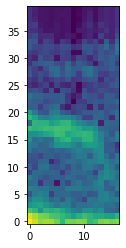

In [ ]:
plt.imshow(spectro, interpolation='nearest', origin='lower', aspect='equal') 

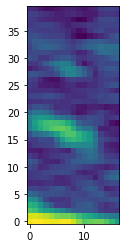

In [ ]:
plt.imshow(call_dict[calltype].denoised_spectrograms, interpolation='nearest', origin='lower', aspect='equal') 

In [ ]:
call_dict[calltype].denoised_spectrograms

array([[ 4.09491196e+01,  4.20954361e+01,  4.18924332e+01,
         4.11344376e+01,  4.04916534e+01,  4.04911461e+01,
         4.15475769e+01,  4.12664413e+01,  3.86218071e+01,
         3.30437927e+01,  2.83594837e+01,  2.96443443e+01,
         3.06468315e+01,  3.09586220e+01,  2.80952358e+01,
         2.40974178e+01,  1.83320580e+01],
       [ 3.86167984e+01,  3.89320717e+01,  3.78984299e+01,
         3.63911934e+01,  3.42476578e+01,  3.14955730e+01,
         3.05568085e+01,  3.05284710e+01,  2.90222778e+01,
         2.53885345e+01,  2.22194748e+01,  2.04725113e+01,
         1.74747562e+01,  1.50526352e+01,  1.23424911e+01,
         1.11171188e+01,  1.01159515e+01],
       [ 2.74771004e+01,  2.59138718e+01,  2.17837315e+01,
         1.92259808e+01,  1.79939651e+01,  1.56865273e+01,
         1.23245010e+01,  8.30053711e+00,  4.93780899e+00,
         4.30166245e+00,  4.16914749e+00,  3.80674362e+00,
         2.26362228e+00, -1.35676193e+00, -2.43782043e+00,
        -2.33113480e+00, -2.7

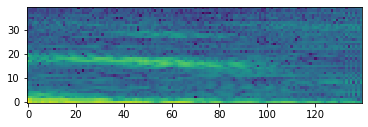

In [ ]:
plt.imshow(call_dict[calltype].denoised_stretched_spectrograms, interpolation='nearest', origin='lower', aspect='equal') 

In [ ]:
call_dict[calltype].denoised_stretched_spectrograms

array([[ 55.75125   ,  48.297333  ,  42.89174   , ...,  21.741638  ,
         22.525665  ,  15.763969  ],
       [ 50.9319    ,  44.340034  ,  38.740173  , ...,   8.297394  ,
         -8.881798  ,   3.8526306 ],
       [ 33.09852   ,  32.96692   ,  30.584894  , ...,  -0.57198334,
          2.075653  ,   0.        ],
       ...,
       [-12.030994  , -10.617016  , -14.672291  , ..., -15.343964  ,
         -3.3580017 ,   0.        ],
       [-12.030994  , -14.833485  , -14.879795  , ...,  -8.103348  ,
         -3.8985443 ,   0.        ],
       [-12.030994  , -10.174831  , -15.314388  , ...,  -0.5628052 ,
          0.80921936,   0.        ]], dtype=float32)

# Debugging augmented function

In [ ]:
# generate different stretches. need orignal raw-audio to do this.
def generate_stretched(audio_data, dur, sr):

    augmented_specs = []

    durations = np.linspace(0.01, MAX_DURATION-0.05, num=3)

    if dur not in durations:
      previous_element = np.max(durations[durations<dur])
      desired_index = np.where(durations==previous_element)[0][0]+1
      durations = np.insert(durations, desired_index, dur)

    n_fft  = int(FFT_WIN * sr) 
    hop_length = int(FFT_HOP * sr)
    
    for desired_duration in durations:
 
      stretch_rate = dur/desired_duration
      D = librosa.stft(y=audio_data, 
                       n_fft = n_fft,
                       hop_length = hop_length,
                       window=WINDOW,
                       win_length = n_fft
                       )
    
      D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
      #D_stretched = librosa.power_to_db(np.abs(D_stretched)**2, ref=np.max) # power to db transform

    
      spectro = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                               sr=sr,
                                               n_mels=N_MELS,
                                               fmax=FMAX)
        
      spectro = librosa.power_to_db(np.abs(spectro)**2, ref=np.max) # power to db transform
      
      # Denoise
      spectro = spectro-np.median(spectro, axis=0)
      
      augmented_specs.append(spectro)

    return augmented_specs

In [ ]:
test = generate_stretched(df.loc[i,'raw_audio'],
                          df.loc[i,'duration_s'],
                          df.loc[i,'samplerate_hz'])

In [ ]:
df.loc[i,'denoised_spectrograms']

In [ ]:
test[1]

In [ ]:
audio_data=df.loc[i,'raw_audio']
dur=df.loc[i,'duration_s']
sr=df.loc[i,'samplerate_hz']

augmented_specs = []

durations = np.linspace(0.01, MAX_DURATION-0.05, num=3)

if dur not in durations:
  previous_element = np.max(durations[durations<dur])
  desired_index = np.where(durations==previous_element)[0][0]+1
  durations = np.insert(durations, desired_index, dur)

n_fft  = int(FFT_WIN * sr) 
hop_length = int(FFT_HOP * sr)

In [ ]:
durations

array([0.01 , 0.061, 0.23 , 0.45 ])

In [ ]:
n_fft  = int(fft_win * sr) 
hop_length = int(fft_hop * sr) 
stretch_rate = 1
D = librosa.stft(y=data, # spectrogramming
                     n_fft = n_fft,
                     hop_length = hop_length,
                     window=window,
                     win_length = n_fft
                     )
    
D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
    
spectro = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                            sr=sr,
                                            n_mels=n_mels,
                                            fmax=4000)
        
s = librosa.power_to_db(np.abs(spectro)**2, ref=np.max) # power to db transform


In [ ]:
for desired_duration in durations:
  stretch_rate = dur/desired_duration
  print(stretch_rate)
  D = librosa.stft(y=audio_data, 
                   n_fft = n_fft,
                   hop_length = hop_length,
                   window=WINDOW,
                   win_length = n_fft
                   )
  print(D[0:3,0:3])

6.1
[[-1.8320898 +0.0000000e+00j -1.451606  +0.0000000e+00j
  -0.670107  +0.0000000e+00j]
 [ 0.49525744-2.4936650e-16j  1.1818118 -1.4692859e-01j
   1.2421964 +1.1923676e+00j]
 [ 1.7186086 +2.1857516e-16j -0.6307016 +1.8463559e+00j
  -2.109183  -1.0276749e+00j]]
1.0
[[-1.8320898 +0.0000000e+00j -1.451606  +0.0000000e+00j
  -0.670107  +0.0000000e+00j]
 [ 0.49525744-2.4936650e-16j  1.1818118 -1.4692859e-01j
   1.2421964 +1.1923676e+00j]
 [ 1.7186086 +2.1857516e-16j -0.6307016 +1.8463559e+00j
  -2.109183  -1.0276749e+00j]]
0.2652173913043478
[[-1.8320898 +0.0000000e+00j -1.451606  +0.0000000e+00j
  -0.670107  +0.0000000e+00j]
 [ 0.49525744-2.4936650e-16j  1.1818118 -1.4692859e-01j
   1.2421964 +1.1923676e+00j]
 [ 1.7186086 +2.1857516e-16j -0.6307016 +1.8463559e+00j
  -2.109183  -1.0276749e+00j]]
0.13555555555555554
[[-1.8320898 +0.0000000e+00j -1.451606  +0.0000000e+00j
  -0.670107  +0.0000000e+00j]
 [ 0.49525744-2.4936650e-16j  1.1818118 -1.4692859e-01j
   1.2421964 +1.1923676e+00j]
 [ 1

In [ ]:
D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
      #D_stretched = librosa.power_to_db(np.abs(D_stretched)**2, ref=np.max) # power to db transform

    
spectro = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                               sr=sr,
                                               n_mels=N_MELS,
                                               fmax=FMAX)
        
spectro = librosa.power_to_db(np.abs(spectro)**2, ref=np.max) # power to db transform

In [ ]:
spectro

array([[ -7.0752144,  -9.825909 ,  -9.324852 , ..., -41.635124 ,
        -53.375465 , -60.36772  ],
       [-11.894569 , -13.784996 , -13.482689 , ..., -49.289024 ,
        -50.07727  , -60.47898  ],
       [-29.727951 , -25.224174 , -21.742798 , ..., -57.3721   ,
        -64.80508  , -74.85746  ],
       ...,
       [-74.85746  , -68.849525 , -66.84408  , ..., -55.73674  ,
        -67.168846 , -72.49462  ],
       [-74.85746  , -73.15798  , -67.05641  , ..., -71.441315 ,
        -64.52807  , -74.85746  ],
       [-74.85746  , -68.3789   , -67.35316  , ..., -56.999367 ,
        -67.34411  , -74.85746  ]], dtype=float32)

# Debugging df generation

What happens if I try to reproduce the stretched spectrograms in df?

In [ ]:
def generate_stretched_mel_spectrogram(data, sr, duration, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * sr) 
    hop_length = int(fft_hop * sr) 
    stretch_rate = duration/MAX_DURATION

    D = librosa.stft(y=data, # spectrogramming
                     n_fft = n_fft,
                     hop_length = hop_length,
                     window=window,
                     win_length = n_fft
                     )
    
    D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
    
    spectro = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                            sr=sr,
                                            n_mels=n_mels,
                                            fmax=4000)
        
    s = librosa.power_to_db(np.abs(spectro)**2, ref=np.max) # power to db transform

    return s

In [ ]:
# Spectrogramming
spectrograms = df.apply(lambda row: generate_stretched_mel_spectrogram(row['raw_audio'],
                                                                            row['samplerate_hz'], 
                                                                            row['duration_s'],
                                                                            N_MELS,
                                                                            WINDOW,
                                                                            FFT_WIN,
                                                                            FFT_HOP),
                        axis=1)

df['test_stretched'] = spectrograms

In [ ]:
# In what row num is call of interest
df[df.index_id.values == call_dict[calltype].index_id].index.values[0]

507

In [ ]:
i=507
df.loc[i,'test_stretched']

array([[ -6.7673054,  -9.525358 ,  -9.034121 , ..., -35.910538 ,
        -43.14209  , -58.785583 ],
       [-11.58666  , -13.482653 , -13.18569  , ..., -49.354782 ,
        -74.54955  , -70.69692  ],
       [-29.420042 , -24.855772 , -21.340967 , ..., -58.22416  ,
        -63.592102 , -74.54955  ],
       ...,
       [-74.54955  , -68.439705 , -66.59815  , ..., -72.99614  ,
        -69.02576  , -74.54955  ],
       [-74.54955  , -72.65617  , -66.80566  , ..., -65.75552  ,
        -69.5663   , -74.54955  ],
       [-74.54955  , -67.99752  , -67.24025  , ..., -58.21498  ,
        -64.858536 , -74.54955  ]], dtype=float32)

In [ ]:
df.loc[i,'stretched_spectrograms']

array([[ -6.7673054,  -9.525358 ,  -9.034121 , ..., -35.910538 ,
        -43.14209  , -58.785583 ],
       [-11.58666  , -13.482653 , -13.18569  , ..., -49.354782 ,
        -74.54955  , -70.69692  ],
       [-29.420042 , -24.855772 , -21.340967 , ..., -58.22416  ,
        -63.592102 , -74.54955  ],
       ...,
       [-74.54955  , -68.439705 , -66.59815  , ..., -72.99614  ,
        -69.02576  , -74.54955  ],
       [-74.54955  , -72.65617  , -66.80566  , ..., -65.75552  ,
        -69.5663   , -74.54955  ],
       [-74.54955  , -67.99752  , -67.24025  , ..., -58.21498  ,
        -64.858536 , -74.54955  ]], dtype=float32)

Okay they are the same, so at least now I know how I produced the stretched spectrograms.

In [ ]:
#stretched_denoised
df.loc[i,'test_stretched'] - np.median(df.loc[i,'test_stretched'], axis=0)

array([[ 55.75125   ,  48.297333  ,  42.89174   , ...,  21.741638  ,
         22.525665  ,  15.763969  ],
       [ 50.9319    ,  44.340034  ,  38.740173  , ...,   8.297394  ,
         -8.881798  ,   3.8526306 ],
       [ 33.09852   ,  32.96692   ,  30.584894  , ...,  -0.57198334,
          2.075653  ,   0.        ],
       ...,
       [-12.030994  , -10.617016  , -14.672291  , ..., -15.343964  ,
         -3.3580017 ,   0.        ],
       [-12.030994  , -14.833485  , -14.879795  , ...,  -8.103348  ,
         -3.8985443 ,   0.        ],
       [-12.030994  , -10.174831  , -15.314388  , ...,  -0.5628052 ,
          0.80921936,   0.        ]], dtype=float32)

In [ ]:
df.loc[i,'stretched_spectrograms'] - np.median(df.loc[i,'stretched_spectrograms'], axis=0)

array([[ 55.75125   ,  48.297333  ,  42.89174   , ...,  21.741638  ,
         22.525665  ,  15.763969  ],
       [ 50.9319    ,  44.340034  ,  38.740173  , ...,   8.297394  ,
         -8.881798  ,   3.8526306 ],
       [ 33.09852   ,  32.96692   ,  30.584894  , ...,  -0.57198334,
          2.075653  ,   0.        ],
       ...,
       [-12.030994  , -10.617016  , -14.672291  , ..., -15.343964  ,
         -3.3580017 ,   0.        ],
       [-12.030994  , -14.833485  , -14.879795  , ...,  -8.103348  ,
         -3.8985443 ,   0.        ],
       [-12.030994  , -10.174831  , -15.314388  , ...,  -0.5628052 ,
          0.80921936,   0.        ]], dtype=float32)

Now if you use stretch_rate=1, what is the result? It should be the same as the spectrogram.

In [ ]:
def generate_stretched_mel_spectrogram_1(data, sr, duration, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * sr) 
    hop_length = int(fft_hop * sr) 
    stretch_rate = 1

    D = librosa.stft(y=data, # spectrogramming
                     n_fft = n_fft,
                     hop_length = hop_length,
                     window=window,
                     win_length = n_fft
                     )
    
    D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
    
    spectro = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                            sr=sr,
                                            n_mels=n_mels,
                                            fmax=4000)
        
    s = librosa.power_to_db(np.abs(spectro)**2, ref=np.max) # power to db transform

    return s

vocoder_effect = generate_stretched_mel_spectrogram_1(df.loc[i,'raw_audio'],
                                                    df.loc[i,'samplerate_hz'],
                                                    df.loc[i,'duration_s'],
                                                    N_MELS,
                                                    WINDOW,
                                                    FFT_WIN,
                                                    FFT_HOP)
vocoder_effect[0:5,0:5]

array([[  0.       ,  -1.9565086,  -6.415249 ,  -4.4224358,  -3.632084 ],
       [ -4.819355 ,  -6.3456917,  -8.837994 , -10.361015 , -14.482193 ],
       [-22.652737 , -22.619564 , -30.950733 , -21.408798 , -22.447475 ],
       [-37.23669  , -30.101353 , -25.082668 , -30.503727 , -34.534275 ],
       [-47.368267 , -34.015095 , -33.104633 , -37.851376 , -45.60397  ]],
      dtype=float32)

In [ ]:
df.loc[i,'spectrograms'][0:5,0:5]

array([[ -4.224742  ,  -2.4976645 ,  -0.63263035,  -0.1849041 ,
         -0.44211006],
       [ -6.557065  ,  -5.661031  ,  -4.6266346 ,  -4.928151  ,
         -6.6861095 ],
       [-17.696762  , -18.67923   , -20.741331  , -22.093363  ,
        -22.9398    ],
       [-21.72743   , -22.69561   , -26.093555  , -32.08461   ,
        -36.769344  ],
       [-29.075706  , -30.343761  , -34.606556  , -41.300877  ,
        -43.35254   ]], dtype=float32)

But that isn't the case. Try re-doing the spectrograms.



In [ ]:
def generate_mel_spectrogram(data, rate, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * rate) 
    hop_length = int(fft_hop * rate) 
        
    s = librosa.feature.melspectrogram(y = data ,
                                       sr = rate, 
                                       n_mels = n_mels , 
                                       fmax = 4000, 
                                       n_fft = n_fft,
                                       hop_length = hop_length, 
                                       window = window, 
                                       win_length = n_fft)

    spectro = librosa.power_to_db(s, ref=np.max)

    return spectro

x=generate_mel_spectrogram(df.loc[i,'raw_audio'],
                         df.loc[i, 'samplerate_hz'],
                         N_MELS,
                         WINDOW,
                         FFT_WIN,
                         FFT_HOP)
x[0:5,0:5]

array([[ -4.224742  ,  -2.4976645 ,  -0.63263035,  -0.1849041 ,
         -0.44211006],
       [ -6.557065  ,  -5.661031  ,  -4.6266346 ,  -4.928151  ,
         -6.6861095 ],
       [-17.696762  , -18.67923   , -20.741331  , -22.093363  ,
        -22.9398    ],
       [-21.72743   , -22.69561   , -26.093555  , -32.08461   ,
        -36.769344  ],
       [-29.075706  , -30.343761  , -34.606556  , -41.300877  ,
        -43.35254   ]], dtype=float32)

In [ ]:
df.loc[i,'spectrograms'][0:5,0:5]

array([[ -4.224742  ,  -2.4976645 ,  -0.63263035,  -0.1849041 ,
         -0.44211006],
       [ -6.557065  ,  -5.661031  ,  -4.6266346 ,  -4.928151  ,
         -6.6861095 ],
       [-17.696762  , -18.67923   , -20.741331  , -22.093363  ,
        -22.9398    ],
       [-21.72743   , -22.69561   , -26.093555  , -32.08461   ,
        -36.769344  ],
       [-29.075706  , -30.343761  , -34.606556  , -41.300877  ,
        -43.35254   ]], dtype=float32)

Okay, the function from audio_to_df actually returns the correct spectrogram. So something might be up with the other function.

In [ ]:
def generate_mel_spectrogram_stft(data, sr, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * sr) 
    hop_length = int(fft_hop * sr) 

    D = librosa.stft(y=data, # spectrogramming
                     n_fft = n_fft,
                     hop_length = hop_length,
                     window=window,
                     win_length = n_fft
                     )
        
    spectro = librosa.feature.melspectrogram(S=D,  # mel transform
                                            sr=sr,
                                            n_mels=n_mels,
                                            fmax=4000)
        
    s = librosa.power_to_db(np.abs(spectro)**2, ref=np.max) # power to db transform

    return s

x=generate_mel_spectrogram_stft(df.loc[i,'raw_audio'],
                         df.loc[i, 'samplerate_hz'],
                         N_MELS,
                         WINDOW,
                         FFT_WIN,
                         FFT_HOP)
x[0:5,0:5]

array([[  0.       ,  -1.9565086,  -6.415249 ,  -4.4224358,  -3.632084 ],
       [ -4.819355 ,  -6.3456917,  -8.837994 , -10.361019 , -14.482193 ],
       [-22.652737 , -22.619564 , -30.950733 , -21.408802 , -22.447472 ],
       [-37.23669  , -30.101353 , -25.082664 , -30.503723 , -34.534267 ],
       [-47.368267 , -34.015095 , -33.104633 , -37.851376 , -45.603962 ]],
      dtype=float32)

In [ ]:
data = df.loc[i,'raw_audio']
sr = df.loc[i,'samplerate_hz']
n_fft  = int(FFT_WIN * sr) 
hop_length = int(FFT_HOP * sr) 

In [ ]:
# Variante 1, via stft
D = librosa.stft(y=data, # spectrogramming
                 n_fft = n_fft,
                 hop_length = hop_length, 
                 window=WINDOW,
                 win_length = n_fft
                 )

#print(D[0:2,0:2])
        
spectro = librosa.feature.melspectrogram(S=D,  # mel transform
                                         sr=sr,
                                         n_mels=N_MELS,
                                         fmax=4000)

print(spectro[0:2,0:2])
#s = librosa.power_to_db(np.abs(spectro)**2, ref=np.max) # power to db transform
#print(s[0:2,0:2])

[[ 0.02449697+1.3347367e-18j  0.00311803+1.9306138e-02j]
 [-0.01406516+1.8867903e-18j  0.00212309-1.1605933e-02j]]


In [ ]:
# Variante 2, direkt:

s = librosa.feature.melspectrogram(y = data ,
                                   sr = sr, 
                                   n_mels = N_MELS ,
                                   fmax = 4000,
                                   n_fft = n_fft,
                                   hop_length = hop_length,
                                   window = WINDOW,
                                   win_length = n_fft)

print(s[0:2,0:2])
spectro = librosa.power_to_db(s, ref=np.max)
print(spectro[0:2,0:2])


[[0.05278288 0.07855988]
 [0.0308504  0.03791964]]
[[-4.224742  -2.4976645]
 [-6.557065  -5.661031 ]]


So these two results differ, while actually, I would expect them to be the same.

In [ ]:
# Variante 1, via stft
D = librosa.stft(y=data, # spectrogramming
                 n_fft = n_fft,
                 hop_length = hop_length, 
                 window=WINDOW,
                 win_length = n_fft
                 )

#print(D[0:2,0:2])

D = np.abs(D)**2
#S = librosa.feature.melspectrogram(S=D, sr=sr)
        
spectro = librosa.feature.melspectrogram(S=D,  # mel transform
                                         sr=sr,
                                         n_mels=N_MELS,
                                         fmax=4000)

print(spectro[0:2,0:2])
#s = librosa.power_to_db(np.abs(spectro)**2, ref=np.max) # power to db transform
s = librosa.power_to_db(spectro, ref=np.max)
print(s[0:2,0:2])

[[0.05278288 0.07855988]
 [0.0308504  0.03791964]]
[[-4.224742  -2.4976645]
 [-6.557065  -5.661031 ]]


Holy shit, this is it! My goodness.. All the stretched data is wrong. So do the np.abs(x)**2 before melspectrogram and then use raw for power_to_db

# Test new stretching function:

In [ ]:
def generate_stretched_mel_spectrogram_NEW(data, sr, duration, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * sr) 
    hop_length = int(fft_hop * sr) 
    #stretch_rate = duration/MAX_DURATION
    stretch_rate = 1

    D = librosa.stft(y=data, # spectrogramming
                     n_fft = n_fft,
                     hop_length = hop_length,
                     window=window,
                     win_length = n_fft
                     )
    
    #D = np.abs(D)**2
    D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
    D_stretched = np.abs(D_stretched)**2

    spectro = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                            sr=sr,
                                            n_mels=n_mels,
                                            fmax=4000)
        
    s = librosa.power_to_db(spectro, ref=np.max) # power to db transform

    return s

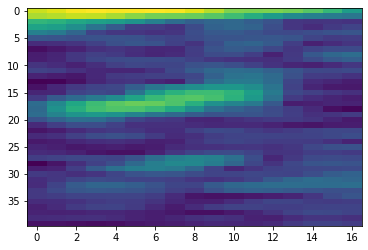

In [ ]:
check = generate_stretched_mel_spectrogram_NEW(df.loc[i,'raw_audio'],
                                                    df.loc[i,'samplerate_hz'],
                                                    df.loc[i,'duration_s'],
                                                    N_MELS,
                                                    WINDOW,
                                                    FFT_WIN,
                                                    FFT_HOP)
plt.imshow(check, interpolation='nearest', aspect='auto')

In [ ]:
check[0:3,0:3]

array([[ -4.224741 ,  -2.4976635,  -0.6326294],
       [ -6.557064 ,  -5.66103  ,  -4.6266336],
       [-17.696762 , -18.67923  , -20.74133  ]], dtype=float32)

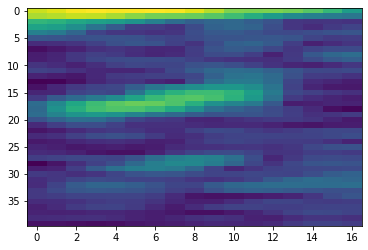

In [ ]:
plt.imshow(df.loc[i,'spectrograms'], interpolation='nearest', aspect='auto')

In [ ]:
df.loc[i,'spectrograms'][0:3,0:3]

array([[ -4.224742  ,  -2.4976645 ,  -0.63263035],
       [ -6.557065  ,  -5.661031  ,  -4.6266346 ],
       [-17.696762  , -18.67923   , -20.741331  ]], dtype=float32)

# Don't remember

Now what if I use the generate_stretched_mel_spectrogram function and stretch_rate=1 ?

In [ ]:
# generate different stretches. need orignal raw-audio to do this.
def generate_stretched_modified(audio_data, dur, sr):

    n_fft  = int(FFT_WIN * sr) 
    hop_length = int(FFT_HOP * sr)
    
 
    stretch_rate = 1
    D = librosa.stft(y=audio_data, 
                        n_fft = n_fft,
                        hop_length = hop_length,
                        window=WINDOW,
                        win_length = n_fft
                        )
      
    D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
        #D_stretched = librosa.power_to_db(np.abs(D_stretched)**2, ref=np.max) # power to db transform

      
    spectro = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                                sr=sr,
                                                n_mels=N_MELS,
                                                fmax=FMAX)
          
    spectro = librosa.power_to_db(np.abs(spectro)**2, ref=np.max) # power to db transform
        

    return spectro


vocoder_effect = generate_stretched_modified(df.loc[i,'raw_audio'],
                                             df.loc[i,'duration_s'],
                                             df.loc[i,'samplerate_hz'])
vocoder_effect

array([[  0.       ,  -1.9565086,  -6.415249 ,  -4.4224358,  -3.632084 ,
         -9.8448105, -19.485886 ,  -9.989742 ,  -5.601162 ,  -4.602127 ,
         -8.707535 , -20.434952 , -14.6297455, -11.831966 , -11.854359 ,
        -13.348911 , -15.400658 ],
       [ -4.819355 ,  -6.3456917,  -8.837994 , -10.361015 , -14.482193 ,
        -16.079632 , -19.253193 , -23.735783 , -23.437233 , -18.96378  ,
        -18.028938 , -21.669365 , -23.476555 , -26.845413 , -31.50241  ,
        -30.744999 , -29.45768  ],
       [-22.652737 , -22.619564 , -30.950733 , -21.408798 , -22.447475 ,
        -20.833569 , -25.331524 , -32.00144  , -33.728832 , -36.884792 ,
        -33.20892  , -33.40588  , -35.19885  , -36.028713 , -49.133907 ,
        -48.53339  , -57.267307 ],
       [-37.23669  , -30.101353 , -25.082668 , -30.503727 , -34.534275 ,
        -40.870266 , -36.822506 , -38.54611  , -42.378223 , -39.037174 ,
        -42.980625 , -42.970013 , -37.788013 , -42.80415  , -47.967884 ,
        -46.1162   

In [ ]:
vocoder_effect-np.median(vocoder_effect, axis=0)

array([[ 55.75125   ,  48.297333  ,  42.89174   , ...,  21.741638  ,
         22.525665  ,  15.763969  ],
       [ 50.9319    ,  44.340034  ,  38.740173  , ...,   8.297394  ,
         -8.881798  ,   3.8526306 ],
       [ 33.09852   ,  32.96692   ,  30.584894  , ...,  -0.57198334,
          2.075653  ,   0.        ],
       ...,
       [-12.030994  , -10.617016  , -14.672291  , ..., -15.343964  ,
         -3.3580017 ,   0.        ],
       [-12.030994  , -14.833485  , -14.879795  , ...,  -8.103348  ,
         -3.8985443 ,   0.        ],
       [-12.030994  , -10.174831  , -15.314388  , ...,  -0.5628052 ,
          0.80921936,   0.        ]], dtype=float32)

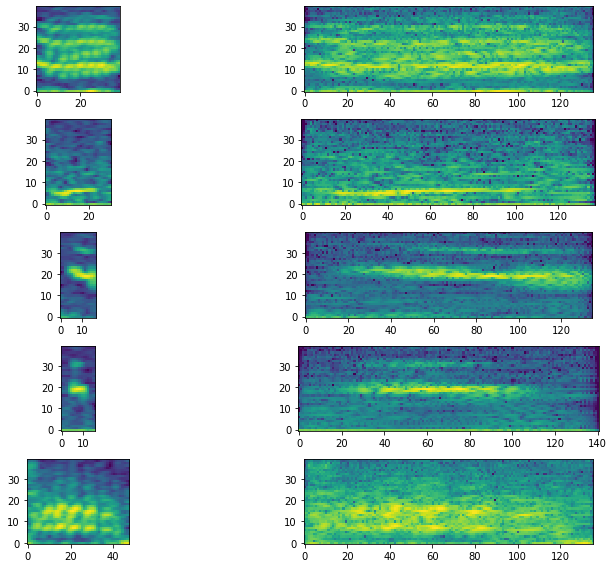

In [ ]:
# Visualize examples
df_subset = df.sample(n = 5, replace=False) 

specs = df_subset.spectrograms.values
specs_stretched = df_subset.stretched_spectrograms.values

plt.figure(figsize=(12, 8))
k=1
for i in range(len(specs)):
  spec = specs[i]
  spec_stretched = specs_stretched[i]
  plt.subplot(5, 2, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  plt.subplot(5, 2, k+1)
  plt.imshow(spec_stretched, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+2
plt.tight_layout()

# Test spectrogram generation

There's a difference between spectrograms generated with phase vocoder and stretch parameter 1 (no stretch) and the original. Find out why.


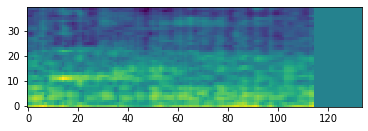

In [ ]:
plt.imshow(augmented_specs[zero_stretch_index], interpolation='nearest', origin='lower', aspect='equal') 

In [ ]:
augmented_specs[zero_stretch_index]

array([[ 0.84843886,  0.89837551,  1.00553775, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.3688066 ,  0.4444136 ,  0.61191368, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.67206424,  0.67686135,  0.77039957, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.52702618, -0.57901406, -0.55019355, ...,  0.        ,
         0.        ,  0.        ],
       [-0.54163098, -0.60179496, -0.63889885, ...,  0.        ,
         0.        ,  0.        ],
       [-0.49842405, -0.44316828, -0.40177476, ...,  0.        ,
         0.        ,  0.        ]])

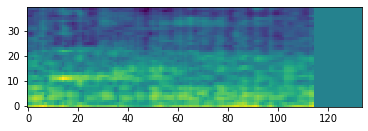

In [ ]:
plt.imshow(original_spec, interpolation='nearest', origin='lower', aspect='equal') 

In [ ]:
original_spec

array([[ 29.32477951,  31.94244385,  34.38698196, ...,   0.        ,
          0.        ,   0.        ],
       [ 19.13557053,  18.83106041,  19.8031044 , ...,   0.        ,
          0.        ,   0.        ],
       [ 20.24888802,  22.38300323,  24.12742805, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-20.32302094, -20.7508049 , -20.60277176, ...,   0.        ,
          0.        ,   0.        ],
       [-19.3224411 , -20.61159134, -23.23249435, ...,   0.        ,
          0.        ,   0.        ],
       [-14.90834808, -14.77343369, -15.13518906, ...,   0.        ,
          0.        ,   0.        ]])

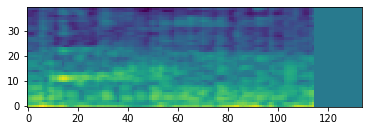

In [ ]:
example = call_dict['soc']
plt.imshow(pad_spectro(example.denoised_spectrograms, maxlen), interpolation='nearest', origin='lower', aspect='equal') 

In [ ]:
pad_spectro(example.denoised_spectrograms, maxlen)

array([[ 29.32477951,  31.94244385,  34.38698196, ...,   0.        ,
          0.        ,   0.        ],
       [ 19.13557053,  18.83106041,  19.8031044 , ...,   0.        ,
          0.        ,   0.        ],
       [ 20.24888802,  22.38300323,  24.12742805, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-20.32302094, -20.7508049 , -20.60277176, ...,   0.        ,
          0.        ,   0.        ],
       [-19.3224411 , -20.61159134, -23.23249435, ...,   0.        ,
          0.        ,   0.        ],
       [-14.90834808, -14.77343369, -15.13518906, ...,   0.        ,
          0.        ,   0.        ]])

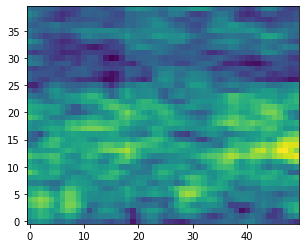

In [ ]:
# Reproduce with old pipeline

def generate_mel_spectrogram(data, rate, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * rate) 
    hop_length = int(fft_hop * rate) 
        
    s = librosa.feature.melspectrogram(y = data ,
                                       sr = rate, 
                                       n_mels = n_mels , 
                                       fmax = 4000, 
                                       n_fft = n_fft,
                                       hop_length = hop_length, 
                                       window = window, 
                                       win_length = n_fft)

    spectro = librosa.power_to_db(s, ref=np.max)

    return spectro


spectrogram = generate_mel_spectrogram(example.raw_audio, example.samplerate_hz,
                                       N_MELS,WINDOW,FFT_WIN,FFT_HOP)
spectrogram = spectrogram - np.median(spectrogram, axis=0)
plt.imshow(spectrogram, interpolation='nearest', origin='lower', aspect='equal') 

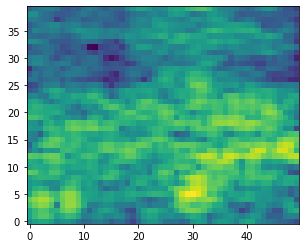

In [ ]:
# Produce with vocoder stretch. First without stretch. Just to compare.
def generate_stretched_mel_spectrogram(data, sr, duration, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * sr) 
    hop_length = int(fft_hop * sr) 
    
    stretch_rate = 1

    D = librosa.stft(y=data, # spectrogramming
                     n_fft = n_fft,
                     hop_length = hop_length,
                     window=window,
                     win_length = n_fft
                     )
    
    D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
    
    D_stretched = librosa.power_to_db(np.abs(D_stretched)**2, ref=np.max) # power to db transform

    s = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                       sr=sr,
                                       n_mels=n_mels,
                                       fmax=4000)
    
    #s = librosa.power_to_db(np.abs(s)**2, ref=np.max) # power to db transform
    
    return s

stretched_spec = generate_stretched_mel_spectrogram(example.raw_audio, example.samplerate_hz, example.duration_s, N_MELS, WINDOW, FFT_WIN, FFT_HOP)
plt.imshow(stretched_spec, interpolation='nearest', origin='lower', aspect='equal') 

# Reste

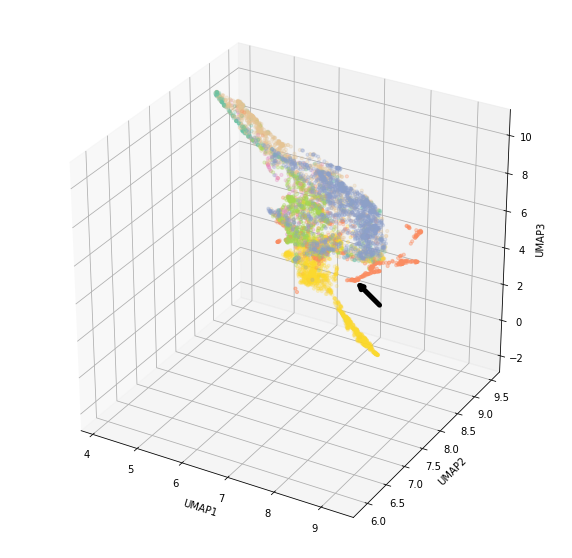

In [ ]:
original_row_num = df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = df['call_lable'].copy()
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))

color_dict = dict(zip(labeltypes, pal))

for key in color_dict.keys():
  color_dict[key] = color_dict[key] +(0.5,)
color_dict[99] = (0,0,0,1) # black

scat_labels = np.asarray(scat_labels)
scat_labels[original_row_num] = 99
scat_labels = list(scat_labels)

# Adding color for representative datapoints
c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               xs = embedding[:-len(augmented_specs),0],
               ys = embedding[:-len(augmented_specs),1],
               zs= embedding[:-len(augmented_specs),2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=True)

# simple way, only text, no arrow:
#ax.text(embedding[original_row_num,0],
#        embedding[original_row_num,1],
#        embedding[original_row_num,2],
#        "example", color='red')

# put in arrow
ax.annotate3D('',(embedding[original_row_num,0],embedding[original_row_num,1],embedding[original_row_num,2]),
              xytext=(30,-30),
              textcoords='offset points',
              bbox=dict(boxstyle="round", fc="lightyellow"),
              arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

plt.show()

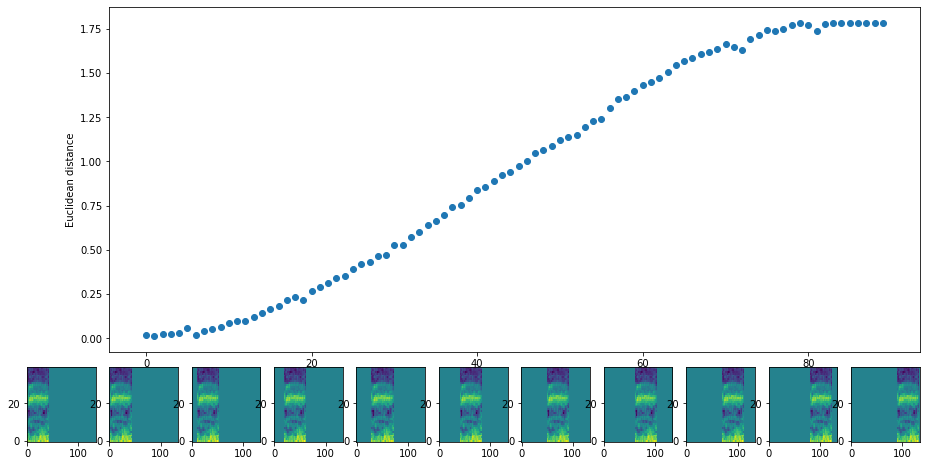

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(5, 11, fig)
fig.add_subplot(gs[:4, 1:])
plt.scatter(range(len(augmented_specs)), distances)
plt.ylabel('Euclidean distance')

# original spec on the very left
fig.add_subplot(gs[4, 0])
plt.imshow(original_spec, interpolation='nearest', origin='lower', aspect='auto') 

# the augmented specs to the right
interval_specs = np.linspace(0, len(augmented_specs)-1, num=10).astype(int)
for i in range(10):
  fig.add_subplot(gs[4, i+1])
  plt.imshow(augmented_specs[interval_specs[i]], interpolation='nearest', origin='lower', aspect='auto') 

In [ ]:
# distances within the same calltype
data_call = specs_embeddings[df.loc[df['call_lable'] == calltype,:].index,:]
distmat_call = distance_matrix(data_call, data_call, p=2)
distmat_call_vals = distmat_call.flatten()
distmat_call_vals = np.delete(distmat_call_vals, np.argwhere(distmat_call_vals == 0))


# distances to other calltypes
data_not_call = specs_embeddings[df.loc[df['call_lable'] != calltype,:].index,:]
distmat_call = distance_matrix(data_call, data_not_call, p=2)
distmat_not_call_vals = distmat_call.flatten()
distmat_not_call_vals = np.delete(distmat_not_call_vals, np.argwhere(distmat_not_call_vals == 0))

# the specific call

# to all other calltypes of that type
distmat_call = distance_matrix(data_call, np.reshape(original_embedding, (1, original_embedding.shape[0])), p=2)
distmat_call_vals_1 = distmat_call.flatten()
distmat_call_vals_1 = np.delete(distmat_call_vals_1, np.argwhere(distmat_call_vals_1 == 0))

# to all other calltypes NOT of that type
distmat_call = distance_matrix(np.reshape(original_embedding, (1, original_embedding.shape[0])), data_not_call, p=2)
distmat_not_call_vals_1 = distmat_call.flatten()
#distmat_not_call_vals_1 = np.delete(distmat_not_call_vals_1, np.argwhere(distmat_not_call_vals_1 == 0))

n, bins, patches = plt.hist(distmat_call_vals, bins=100, alpha=0.5, color='green')
n, bins, patches = plt.hist(distmat_not_call_vals, bins=100, alpha=0.2, color='red')
#plt.xlim([0, 14])
plt.title("All calls")
plt.show()

n, bins, patches = plt.hist(distmat_call_vals_1, bins=100, alpha=0.5, color='green')
n, bins, patches = plt.hist(distmat_not_call_vals_1, bins=100, alpha=0.2, color='red')
#plt.xlim([0, 14])
plt.title("Specific call")
plt.show()

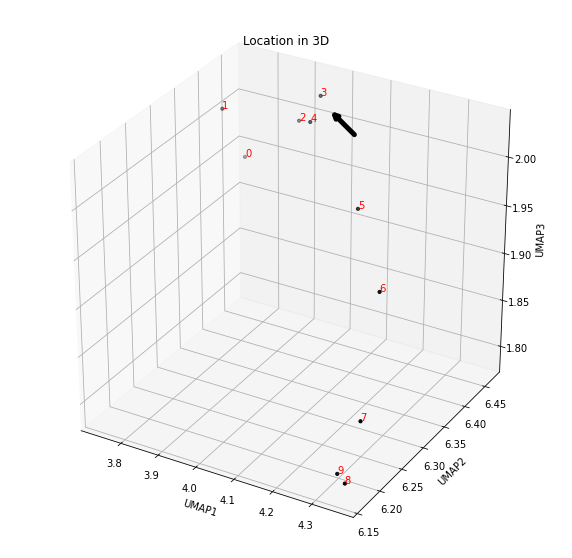

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = np.arange(0,10,1)
c = [(0,0,0,1) for val in scat_labels]

Axes3D.scatter(ax,
               #xs = embedding[:-len(augmented_specs),0],
               #ys = embedding[:-len(augmented_specs),1],
               #zs= embedding[:-len(augmented_specs),2],
               xs = augmented_10_embeddings[:,0],
               ys = augmented_10_embeddings[:,1],
               zs= augmented_10_embeddings[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=True)

# put in arrow
if augment_type=='stretch':
  ax.annotate3D('',(augmented_embeddings[zero_stretch_index,0],augmented_embeddings[zero_stretch_index,1],augmented_embeddings[zero_stretch_index,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))
else:
  ax.annotate3D('',(embedding[original_row_num,0],embedding[original_row_num,1],embedding[original_row_num,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))

# simple way, only text, no arrow:
for i in scat_labels:
  ax.text(augmented_10_embeddings[i,0],
          augmented_10_embeddings[i,1],
          augmented_10_embeddings[i,2],
          str(i), color='red')


ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('Location in 3D')
plt.show()

# Files for Frants

In [ ]:
df.shape

(6687, 36)

In [ ]:
def extract_padded(id, label, wav_loc, start_s, duration_s):
 
  duration_s = duration_s+0.2
  start_s = start_s-0.1

  filename = str(id)+'_'+label+'.wav'

  if start_s>0:
    data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None, mono=False)
    librosa.output.write_wav(DATA+'frants_padded/padded_'+filename, data, rate, norm=False)

In [ ]:
x=df.apply(lambda row: extract_padded(row['index_id'],
                                    row['call_lable'],
                                    row['original_wav'],
                                    row['start_s'],
                                    row['duration_s']),
         axis=1)
